In [664]:
# import module
from pdf2image import convert_from_path
 
# Store Pdf with convert_from_path function
images = convert_from_path('constituency.pdf')
 
for i in range(len(images)):
   
      # Save pages as images in the pdf
    images[i].save('page'+ str(i) +'.png', 'PNG')

KeyboardInterrupt: 

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import pytesseract
import re
from concurrent.futures import ThreadPoolExecutor, as_completed

# OCR

In [ ]:
def extract_text(url, page_no):
    print("Start Page", page_no)
    pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

    img = cv2.imread(url,0)
    img_1 = cv2.cvtColor(cv2.imread(url), cv2.COLOR_BGR2GRAY)    
    blurred = cv2.blur(img, ksize = [3,3])
    canny = cv2.Canny(blurred, 20, 200)
    canny_2 = cv2.Canny(img_1, 10, 200)
    linesP = cv2.HoughLinesP(canny_2, 1, np.pi/180, 200, minLineLength=100, maxLineGap=3)

    contours, _ = cv2.findContours(canny, 
        cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    def is_inside(rectangle, all_rectangles, check_width = 50, check_height = 50, penalty = 0):
        if (rectangle[2] > check_width) or (rectangle[3] > check_height):
            return True
        for rec_check in all_rectangles:
            if rec_check == rectangle:
                continue
            if (rec_check[2] > check_width) or (rec_check[3] > check_height):
                continue
            if (rec_check[0] <= rectangle[0] + penalty) and (rec_check[1] <= rectangle[1] + penalty)\
                and (rec_check[0] + rec_check[2] + penalty >= rectangle[0] + rectangle[2])\
                and (rec_check[1] + rec_check[3] + penalty >= rectangle[1] + rectangle[3]):
                return True
        return False

    def get_bigger_rec(values):
        min_x = values[0][0]
        min_y = values[0][1]
        max_x = values[0][0] + values[0][2]
        max_y = values[0][1] + values[0][3]
        for value in values:
            if value[0] <= min_x: min_x = value[0]
            if value[1] <= min_y: min_y = value[1]
            if value[0] + value[2] >= max_x: max_x = value[0] + value[2]
            if value[1] + value[3] >= max_y: max_y = value[1] + value[3]
        return min_x, min_y, max_x, max_y
        
    def clustering_recs(refined_rectangles, scale_y = 10, epsilon = 50, min_samples = 2):
        y_min = []
        for rectangle in refined_rectangles:
            y_min.append([(rectangle[1] + rectangle[3] / 2) * scale_y, rectangle[0]])

        clustering = DBSCAN(eps = epsilon, min_samples = min_samples).fit(y_min)
        list_labels = clustering.labels_
        cluster = dict()
        for index in range(len(list_labels)):
            try:
                cluster[list_labels[index]].append(refined_rectangles[index])
            except:
                cluster[list_labels[index]] = [refined_rectangles[index]]

        cluster_rec = []
        for key, values in cluster.items():
            if key != -1:
                min_x, min_y, max_x, max_y = get_bigger_rec(values)
                cluster_rec.append([min_x, min_y, max_x - min_x, max_y - min_y])
            else:
                cluster_rec += values
        
        final_rectangles = []
        for rectangle in cluster_rec:
            if not(is_inside(rectangle, cluster_rec, penalty = 2, check_width= 1e6, check_height = 1e6)):
                final_rectangles.append(rectangle)
        return final_rectangles

    def find_ybox(rec, x_min, x_max):
        first = True
        for num in range(rec[1], rec[1]+rec[3]):
            if ((255 - img[num, x_min:x_max]).sum() != 0) and first:
                if num > rec[1] + 10:
                    start_y = rec[1]
                else:
                    start_y = rec[1] - 10
                first = False
            elif ((255 - img[num, x_min:x_max]).sum() == 0) and not(first):
                if num < rec[1] + rec[3] - 5:
                    stop_y = rec[1] + rec[3]
                else:
                    stop_y = rec[1] + rec[3] + 5
            else:
                stop_y = rec[1] + rec[3] + 5
        return start_y, stop_y

    def tesseract_thai(image):
        config = r"--oem 1 --psm 8"
        text = pytesseract.image_to_string(image, lang = "sarabun", config=config)[:-1].replace(" ", "")
        if re.findall("[๔๕]|ตําบล", text) != []:
            return pytesseract.image_to_string(image, lang = "tha", config=config)[:-1].replace(" ", "").replace("@", "๑")
        elif text not in ["|", "["]:
            return text.replace("@", "๑")
        else:
            return ""
        
    def grouping_recs(final_rectangles, gap = 5, gap_x = 0, y_scale = 100, x = False, dont_care = False, max_size_y = 100):
        group = []
        for rec in final_rectangles:
            if group == []:
                group.append([rec])
            else:
                new_group = []
                keys = []
                appended = False
                for key in range(len(group)):
                    for value in group[key]:
                        if ((value[1] - gap <= rec[1] <= value[1] + value[3] + gap) or\
                            (value[1] - gap <= rec[1] + rec[3] <= value[1] + value[3] + gap)) or\
                            ((rec[1] - gap <= value[1] <= rec[1] + rec[3] + gap) or\
                            (rec[1] - gap <= value[1] + value[3] <= rec[1] + rec[3] + gap)):
                            if x:
                                if (((value[0] - gap_x <= rec[0] <= value[0] + value[2] + gap_x) and\
                                (value[0] - gap_x <= rec[0] + rec[2] <= value[0] + value[2] + gap_x)) or\
                                ((rec[0] - gap_x <= value[0] <= rec[0] + rec[2] + gap_x) and\
                                (rec[0] - gap_x <= value[0] + value[2] <= rec[0] + rec[2] + gap_x))) and\
                                ((y_scale * min(value[3], rec[3]) < max(value[3],rec[3]))) and\
                                (min(rec[3], value[3]) < max_size_y or dont_care):
                                    keys.append(key)
                                    appended = True
                                    break
                            else:
                                if (y_scale * min(value[3], rec[3]) < max(value[3],rec[3]) or dont_care):
                                    keys.append(key)
                                    appended = True
                                    break
                if not(appended):
                    group.append([rec])
                else:
                    for i in range(len(group)):
                        if i not in keys:
                            new_group.append(group[i])
                    new_group.append(group[keys[0]])
                    for key in keys[1:]:
                        new_group[-1] += group[key]
                    new_group[-1] += [rec]
                    group = new_group

        last_recs = []
        for values in group:
            min_x, min_y, max_x, max_y = get_bigger_rec(values)
            last_y = min_y
            tmp_y = min_y
            count = 0
            for y in range(min_y, max_y):
                if (255 - img[y, min_x:max_x]).sum() == 0:
                    count += 1
                    if count > 5: last_y = y
                else:
                    count = 0
                    tmp_y = last_y
            last_recs.append([min_x, tmp_y, max_x - min_x, max_y - tmp_y])
        return last_recs

    all_rectangles = []
    for contour in contours:
        if len(contour.tolist()) > 1:
            x,y,w,h = cv2.boundingRect(contour)
            all_rectangles.append([x,y,w,h])

    refined_rectangles = []
    for rectangle in all_rectangles:
        if not(is_inside(rectangle, all_rectangles)) and not(rectangle[2] < 7 and rectangle[3] > 10) and not(rectangle[2] < 10 and (rectangle[2] == rectangle[3])):
            refined_rectangles.append(rectangle)

    min_cluster = 1e6
    epsilon = 100
    min_samples = 2
    k_opt = 10
    l_opt = 1
    change = 0
    for i in [100]:
        for j in [5,6]:
            for k in [10]:
                for l in [1]:
                    area_test = np.zeros(img.shape)

                    final_rectangles = clustering_recs(refined_rectangles, epsilon = i, min_samples = j)
                    last_recs_1 = grouping_recs(final_rectangles, gap = 0, x = True)
                    last_recs_2 = grouping_recs(last_recs_1, gap = 0, gap_x = 5, x = True, y_scale = 1)
                    last_recs_3 = grouping_recs(last_recs_2, gap = l, gap_x = 5, x = True, y_scale = 1.5)
                    last_recs_4 = clustering_recs(last_recs_3, scale_y = 10, epsilon = k)
                    last_recs = grouping_recs(last_recs_4, gap = 0, gap_x = 5, x = True, y_scale = 1)
                    final_final_recs = [[rec[0] - 5, rec[1] - 5, rec[2] + 10, rec[3] + 10] for rec in last_recs]

                    for rec in final_final_recs:
                        area_test[rec[0]:rec[0]+rec[2], rec[1]:rec[1]+rec[3]] = 1
                    area_test = area_test - ((255 - img) / 255).round()

                    metric = area_test.sum()
                    if metric < min_cluster:
                        change += 1
                        epsilon = i
                        min_samples = j
                        k_opt = k
                        l_opt = l
                        min_cluster = metric

    final_rectangles = clustering_recs(refined_rectangles, epsilon = epsilon, min_samples = min_samples)
    last_recs_1 = grouping_recs(final_rectangles, gap = 0, x = True)
    last_recs_2 = grouping_recs(last_recs_1, gap = 0, gap_x = 5, x = True, y_scale = 1)
    last_recs_3 = grouping_recs(last_recs_2, gap = l_opt, gap_x = 5, x = True, y_scale = 1.5)
    last_recs_4 = clustering_recs(last_recs_3, scale_y = 10, epsilon = k_opt)
    last_recs_5 = grouping_recs(last_recs_4, gap = 0, gap_x = 5, x = True, y_scale = 2)
    last_recs_6 = grouping_recs(last_recs_5, gap = 0, gap_x = 5, x = False, y_scale = 1.25)
    last_recs = grouping_recs(last_recs_6, gap = 0, gap_x = 0, x = False, dont_care = True)
    final_final_recs_1 = [[rec[0] - 10, rec[1] - 10, rec[2] + 10, rec[3] + 10] for rec in last_recs]
    final_final_recs = grouping_recs(final_final_recs_1, gap = 0, gap_x = 0, x = True, max_size_y = 20, y_scale = 1)

    string = ""

    def vert_gen(last_px, last_last_px, rec, linesP, add = " "):
        string = ""
        last_x_line = -1e6
        for line in sorted(linesP, key = lambda x: x[0][0]):
            min_y_line = min(line[0][1], line[0][3])
            max_y_line = max(line[0][1], line[0][3])
            if (line[0][0] == line[0][2]) and\
                (line[0][0] - last_x_line > 50) and\
                (last_last_px <= line[0][0] and line[0][0] <= last_px) and\
                ((min_y_line <= rec[1] + rec[3]) and (rec[1] <= max_y_line)):
                string += "|" + add
                last_x_line = line[0][0]
        if (add == " "): return string
        else:
            if string in ["", "|" + add]: return "--------"
            else: return string

    for idx in range(len(recs := sorted(final_final_recs, key = lambda x: x[1]))):
        rec = recs[idx]
        last_rec = recs[idx - 1]
        for line in linesP:
            if (line[0][1] == line[0][3]) and (last_rec[1] + last_rec[3] / 2 <= line[0][1] and line[0][1] <= rec[1] + rec[3] / 2):
                string += vert_gen(
                    img.shape[1], 0,
                    [
                        line[0][0],
                        line[0][1],
                        line[0][2] - line[0][0],
                        line[0][3] - line[0][1]
                    ],
                    linesP, add = " --- ")
                string = string[:-5] if string[-1] == " " else string
                string += "\n"
                break
        last_px = rec[0]
        last_last_px = 0
        count = 0
        
        string += vert_gen(last_px, last_last_px, rec, linesP)
        
        new_img = img.copy()
        for j in range(rec[1], rec[1] + rec[3]):
            if (new_img[j, rec[0]: rec[0] + rec[2]].sum() == 0):
                new_img[j, rec[0]: rec[0] + rec[2]] = 255
        for i in range(rec[0], rec[0] + rec[2]):
            if ((255 - new_img[rec[1]:rec[1] + rec[3], i]).sum() / 255 < 2):
                count += 1
            else:
                if count >= 10:
                    last_last_px = last_px
                    last_px = i - 5
                    string += vert_gen(last_px, last_last_px, rec, linesP)
                count = 0
            if (count == 10):
                string += tesseract_thai(new_img[rec[1]:rec[1] + rec[3], last_px:i]) + " "
            if (count == 100):
                string += "\t"
        if count < 10:
            string += tesseract_thai(new_img[rec[1]:rec[1] + rec[3], last_px:i]) + " "
        string += vert_gen(img.shape[1], last_px, rec, linesP)
        string += "\n"
    print("Page", page_no, "Finished")
    return [page_no, string]

## For testing

In [ ]:
no = 43

img = cv2.imread("Constituencies/page{}.png".format(no),0)
img_1 = cv2.cvtColor(cv2.imread("Constituencies/page{}.png".format(no)), cv2.COLOR_BGR2GRAY)
blurred = cv2.blur(img, ksize = [3,3])
canny = cv2.Canny(blurred, 20, 200)
canny_2 = cv2.Canny(img_1, 10, 200)
linesP = cv2.HoughLinesP(canny_2, 1, np.pi/180, 200, minLineLength=100, maxLineGap=3)

contours, _ = cv2.findContours(canny, 
    cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

def is_inside(rectangle, all_rectangles, check_width = 50, check_height = 50, penalty = 0):
    if (rectangle[2] > check_width) or (rectangle[3] > check_height):
        return True
    for rec_check in all_rectangles:
        if rec_check == rectangle:
            continue
        if (rec_check[2] > check_width) or (rec_check[3] > check_height):
            continue
        if (rec_check[0] <= rectangle[0] + penalty) and (rec_check[1] <= rectangle[1] + penalty)\
            and (rec_check[0] + rec_check[2] + penalty >= rectangle[0] + rectangle[2])\
            and (rec_check[1] + rec_check[3] + penalty >= rectangle[1] + rectangle[3]):
            return True
    return False

def get_bigger_rec(values):
    min_x = values[0][0]
    min_y = values[0][1]
    max_x = values[0][0] + values[0][2]
    max_y = values[0][1] + values[0][3]
    for value in values:
        if value[0] <= min_x: min_x = value[0]
        if value[1] <= min_y: min_y = value[1]
        if value[0] + value[2] >= max_x: max_x = value[0] + value[2]
        if value[1] + value[3] >= max_y: max_y = value[1] + value[3]
    return min_x, min_y, max_x, max_y
    
def clustering_recs(refined_rectangles, scale_y = 10, epsilon = 50, min_samples = 2):
    y_min = []
    for rectangle in refined_rectangles:
        y_min.append([(rectangle[1] + rectangle[3] / 2) * scale_y, rectangle[0]])

    clustering = DBSCAN(eps = epsilon, min_samples = min_samples).fit(y_min)
    list_labels = clustering.labels_
    cluster = dict()
    for index in range(len(list_labels)):
        try:
            cluster[list_labels[index]].append(refined_rectangles[index])
        except:
            cluster[list_labels[index]] = [refined_rectangles[index]]

    cluster_rec = []
    for key, values in cluster.items():
        if key != -1:
            min_x, min_y, max_x, max_y = get_bigger_rec(values)
            cluster_rec.append([min_x, min_y, max_x - min_x, max_y - min_y])
        else:
            cluster_rec += values
    
    final_rectangles = []
    for rectangle in cluster_rec:
        if not(is_inside(rectangle, cluster_rec, penalty = 2, check_width= 1e6, check_height = 1e6)):
            final_rectangles.append(rectangle)
    return final_rectangles

def find_ybox(rec, x_min, x_max):
    first = True
    for num in range(rec[1], rec[1]+rec[3]):
        if ((255 - img[num, x_min:x_max]).sum() != 0) and first:
            if num > rec[1] + 10:
                start_y = rec[1]
            else:
                start_y = rec[1] - 10
            first = False
        elif ((255 - img[num, x_min:x_max]).sum() == 0) and not(first):
            if num < rec[1] + rec[3] - 5:
                stop_y = rec[1] + rec[3]
            else:
                stop_y = rec[1] + rec[3] + 5
        else:
            stop_y = rec[1] + rec[3] + 5
    return start_y, stop_y

def tesseract_thai(image):
    config = r"--oem 1 --psm 8"
    text = pytesseract.image_to_string(image, lang = "sarabun", config=config)[:-1].replace(" ", "")
    if re.findall("[๔๕]|ตําบล", text) != []:
        return pytesseract.image_to_string(image, lang = "tha", config=config)[:-1].replace(" ", "").replace("@", "๑")
    elif text not in ["|", "["]:
        return text.replace("@", "๑")
    else:
        return ""
    
def grouping_recs(final_rectangles, gap = 5, gap_x = 0, y_scale = 100, x = False, dont_care = False, max_size_y = 100):
    group = []
    for rec in final_rectangles:
        if group == []:
            group.append([rec])
        else:
            new_group = []
            keys = []
            appended = False
            for key in range(len(group)):
                for value in group[key]:
                    if ((value[1] - gap <= rec[1] <= value[1] + value[3] + gap) or\
                        (value[1] - gap <= rec[1] + rec[3] <= value[1] + value[3] + gap)) or\
                        ((rec[1] - gap <= value[1] <= rec[1] + rec[3] + gap) or\
                        (rec[1] - gap <= value[1] + value[3] <= rec[1] + rec[3] + gap)):
                        if x:
                            if (((value[0] - gap_x <= rec[0] <= value[0] + value[2] + gap_x) and\
                            (value[0] - gap_x <= rec[0] + rec[2] <= value[0] + value[2] + gap_x)) or\
                            ((rec[0] - gap_x <= value[0] <= rec[0] + rec[2] + gap_x) and\
                            (rec[0] - gap_x <= value[0] + value[2] <= rec[0] + rec[2] + gap_x))) and\
                            ((y_scale * min(value[3], rec[3]) < max(value[3],rec[3]))) and\
                            (min(rec[3], value[3]) < max_size_y or dont_care):
                                keys.append(key)
                                appended = True
                                break
                        else:
                            if (y_scale * min(value[3], rec[3]) < max(value[3],rec[3]) or dont_care):
                                keys.append(key)
                                appended = True
                                break
            if not(appended):
                group.append([rec])
            else:
                for i in range(len(group)):
                    if i not in keys:
                        new_group.append(group[i])
                new_group.append(group[keys[0]])
                for key in keys[1:]:
                    new_group[-1] += group[key]
                new_group[-1] += [rec]
                group = new_group

    last_recs = []
    for values in group:
        min_x, min_y, max_x, max_y = get_bigger_rec(values)
        last_y = min_y
        tmp_y = min_y
        count = 0
        for y in range(min_y, max_y):
            if (255 - img[y, min_x:max_x]).sum() == 0:
                count += 1
                if count > 5: last_y = y
            else:
                count = 0
                tmp_y = last_y
        last_recs.append([min_x, tmp_y, max_x - min_x, max_y - tmp_y])
    return last_recs

all_rectangles = []
for contour in contours:
    if len(contour.tolist()) > 1:
        x,y,w,h = cv2.boundingRect(contour)
        all_rectangles.append([x,y,w,h])

refined_rectangles = []
for rectangle in all_rectangles:
    if not(is_inside(rectangle, all_rectangles)) and not(rectangle[2] < 7 and rectangle[3] > 10) and not(rectangle[2] < 10 and (rectangle[2] == rectangle[3])):
        refined_rectangles.append(rectangle)

min_cluster = 1e6
epsilon = 100
min_samples = 2
k_opt = 10
l_opt = 1
change = 0
for i in [100]:
    for j in [5,6]:
        for k in [10]:
            for l in [1]:
                area_test = np.zeros(img.shape)

                final_rectangles = clustering_recs(refined_rectangles, epsilon = i, min_samples = j)
                last_recs_1 = grouping_recs(final_rectangles, gap = 0, x = True)
                last_recs_2 = grouping_recs(last_recs_1, gap = 0, gap_x = 5, x = True, y_scale = 1)
                last_recs_3 = grouping_recs(last_recs_2, gap = l, gap_x = 5, x = True, y_scale = 1.5)
                last_recs_4 = clustering_recs(last_recs_3, scale_y = 10, epsilon = k)
                last_recs = grouping_recs(last_recs_4, gap = 0, gap_x = 5, x = True, y_scale = 1)
                final_final_recs = [[rec[0] - 5, rec[1] - 5, rec[2] + 10, rec[3] + 10] for rec in last_recs]

                for rec in final_final_recs:
                    area_test[rec[0]:rec[0]+rec[2], rec[1]:rec[1]+rec[3]] = 1
                area_test = area_test - ((255 - img) / 255).round()

                metric = area_test.sum()
                if metric < min_cluster:
                    change += 1
                    epsilon = i
                    min_samples = j
                    k_opt = k
                    l_opt = l
                    min_cluster = metric

print(epsilon,min_samples,k_opt,l_opt)

final_rectangles = clustering_recs(refined_rectangles, epsilon = epsilon, min_samples = min_samples)
last_recs_1 = grouping_recs(final_rectangles, gap = 0, x = True)
last_recs_2 = grouping_recs(last_recs_1, gap = 0, gap_x = 5, x = True, y_scale = 1)
last_recs_3 = grouping_recs(last_recs_2, gap = l_opt, gap_x = 5, x = True, y_scale = 1.5)
last_recs_4 = clustering_recs(last_recs_3, scale_y = 10, epsilon = k_opt)
last_recs_5 = grouping_recs(last_recs_4, gap = 0, gap_x = 5, x = True, y_scale = 2)
last_recs_6 = grouping_recs(last_recs_5, gap = 0, gap_x = 5, x = False, y_scale = 1.25)
last_recs = grouping_recs(last_recs_6, gap = 0, gap_x = 0, x = False, dont_care = True)
final_final_recs = [[rec[0] - 10, rec[1] - 10, rec[2] + 10, rec[3] + 10] for rec in last_recs]

100 6 10 1


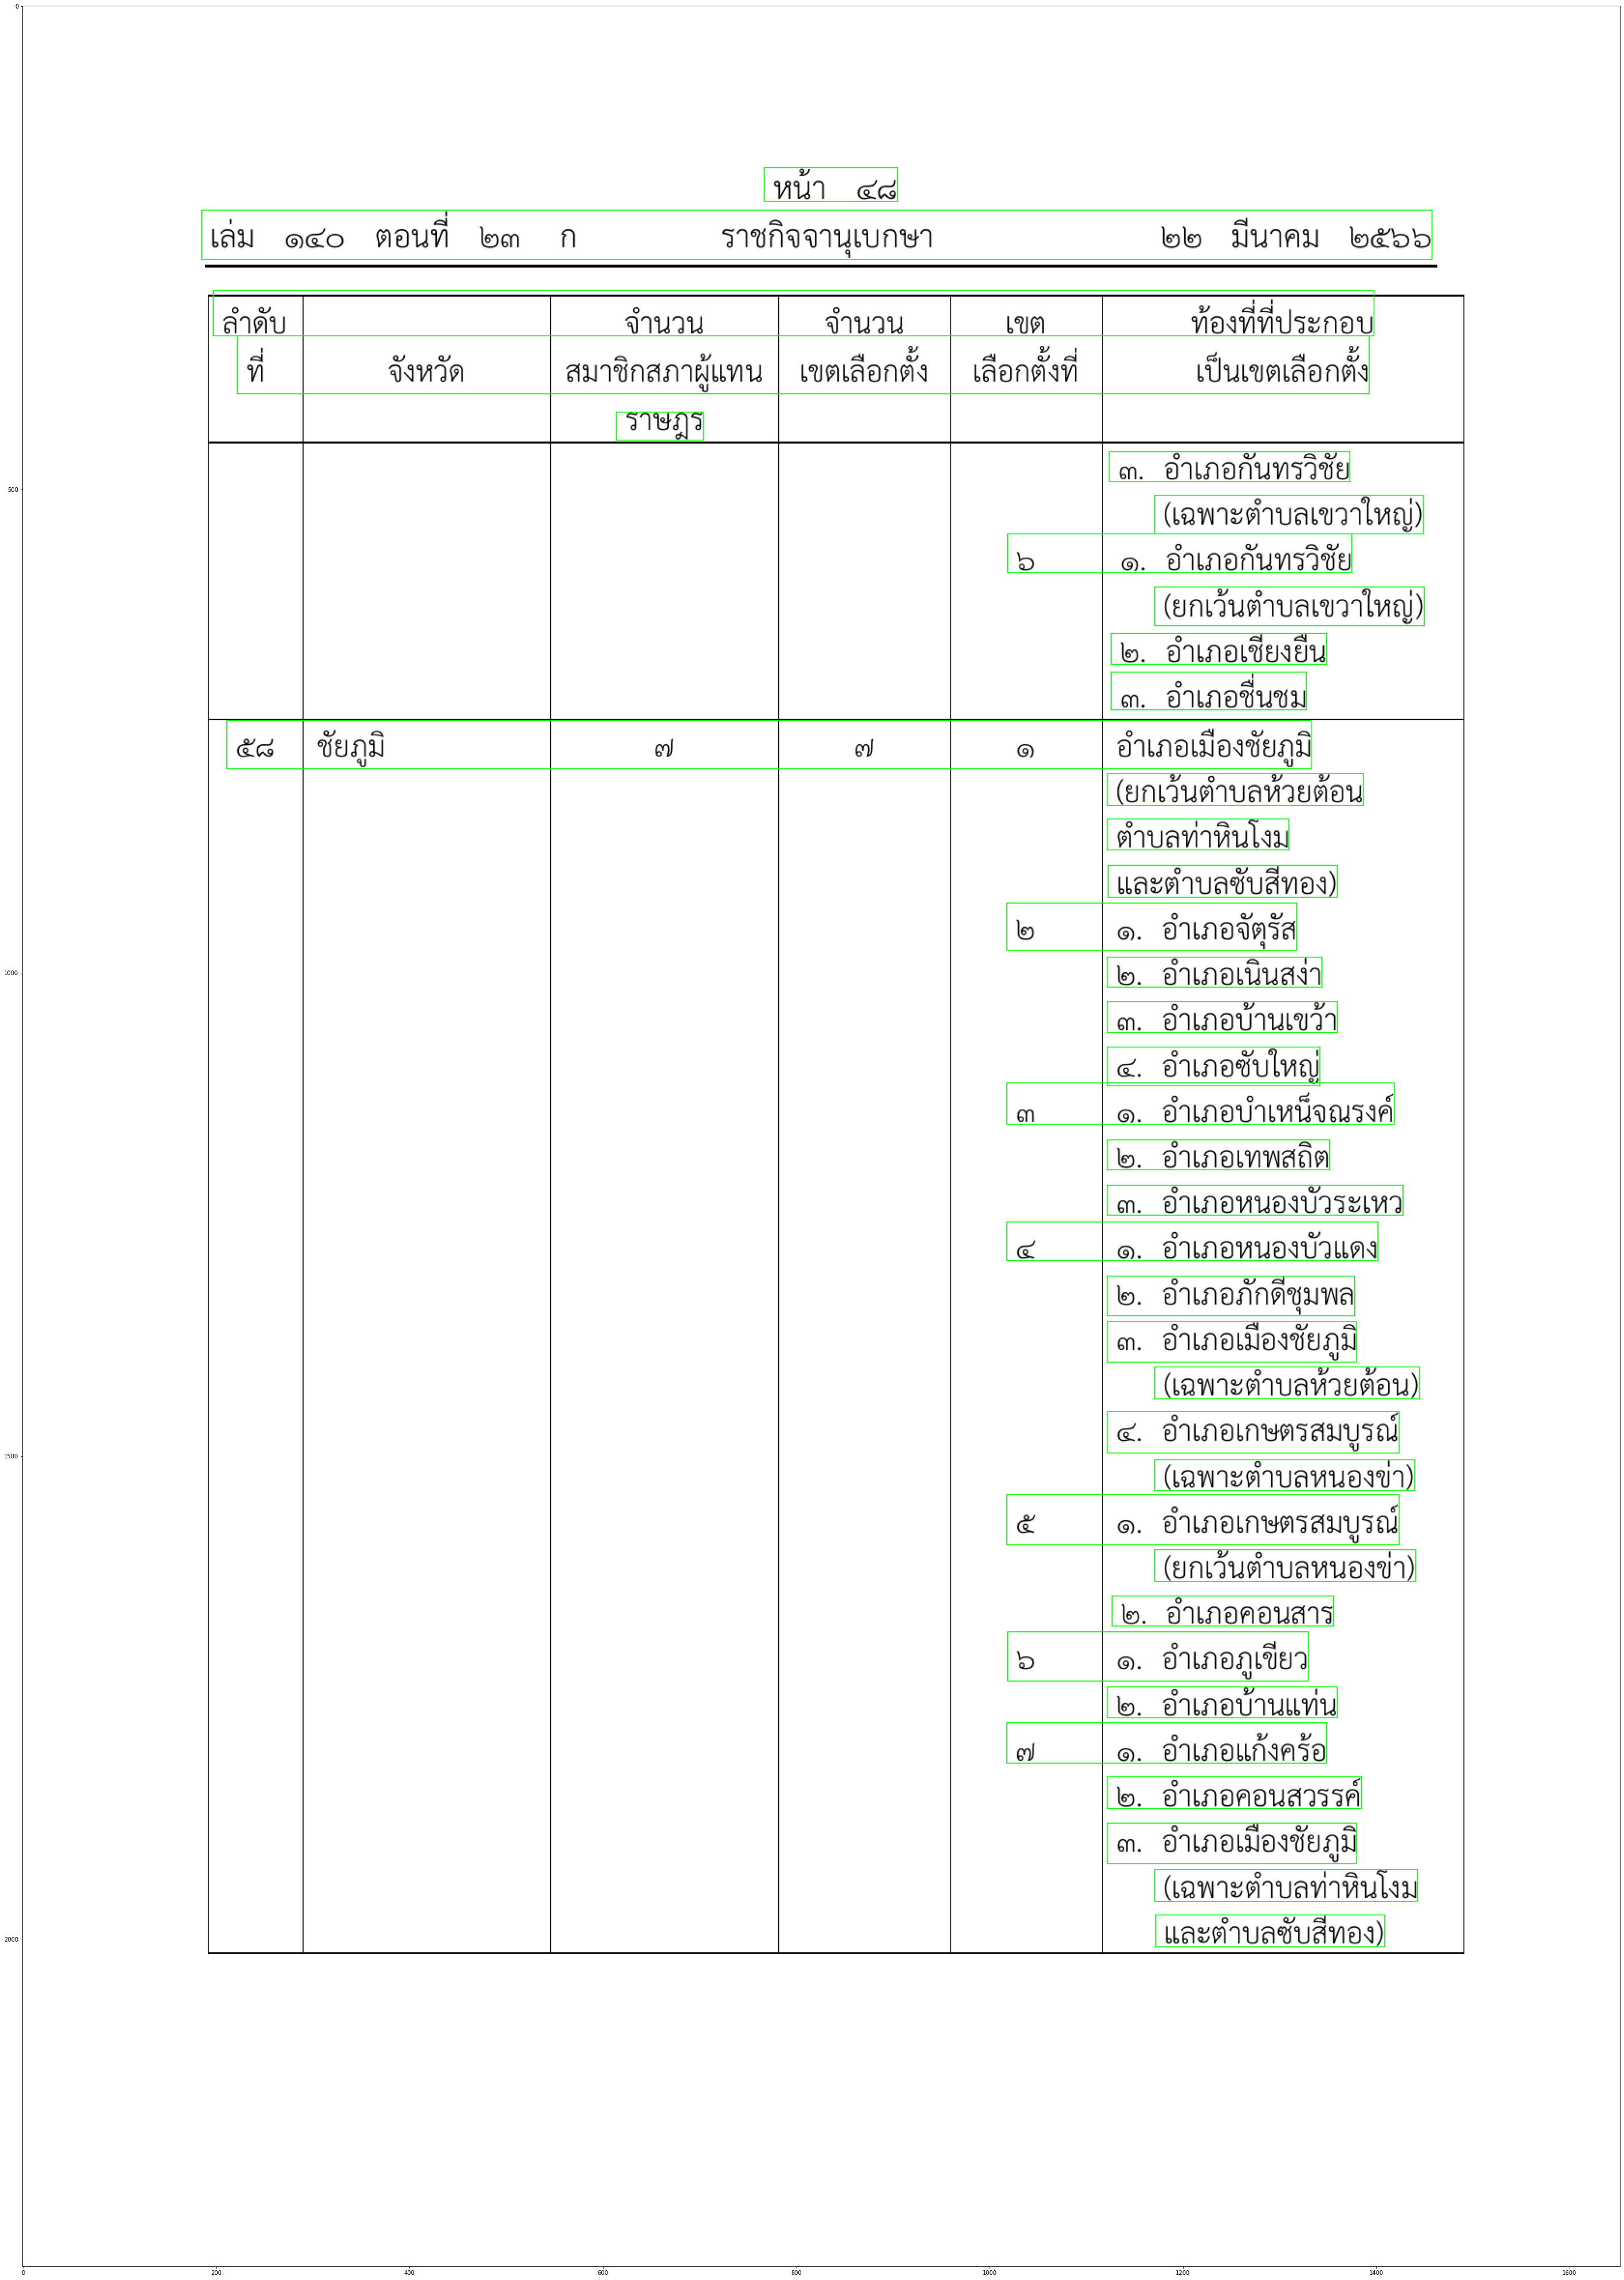

In [ ]:
final = img.copy()
final = cv2.cvtColor(final, cv2.COLOR_GRAY2BGR)
for rec in grouping_recs(final_final_recs, gap = 0, gap_x = 0, x = True, max_size_y = 20, y_scale = 1):
    final = cv2.rectangle(final, [rec[0], rec[1]], [rec[0] + rec[2], rec[1] + rec[3]], (0,255,0))
# for line in linesP:
#     final = cv2.line(final, [line[0][0], line[0][1]], [line[0][2], line[0][3]], (255,0,0))

plt.figure(figsize = (50,100))
plt.imshow(final)
plt.show()

## Testing

In [ ]:
with ThreadPoolExecutor() as processes:
    tasks = []
    for no in range(87):
        tasks.append(processes.submit(extract_text, "Constituencies/page{}.png".format(no), no))
    all_strings = []
    for final_result in as_completed(tasks):
        all_strings.append(final_result.result())

# extract_text("Constituencies/page{}.png".format(0), 0)[1].split("\n")

Start Page 0
Start Page 1
Start Page 2
Start Page 3
Start Page 4
Start Page 5
Start Page 6
Start Page 7
Start Page 8
Start Page 9
Start Page 10
Start Page 11
Page 5 Finished
Start Page 12
Page 11 Finished
Start Page 13
Page 6 Finished
Start Page 14
Page 8 Finished
Start Page 15
Page 2 Finished
Start Page 16
Page 3 Finished
Start Page 17
Page 10 Finished
Start Page 18
Page 7 Finished
Start Page 19
Page 9 Finished
Start Page 20
Page 4 Finished
Start Page 21
Page 1 Finished
Start Page 22
Page 0 Finished
Start Page 23
Page 13 Finished
Start Page 24
Page 14 Finished
Start Page 25
Page 12 Finished
Start Page 26
Page 17 Finished
Start Page 27
Page 20 Finished
Start Page 28
Page 16 Finished
Start Page 29
Page 19 Finished
Start Page 30
Page 18 Finished
Start Page 31
Page 15 Finished
Start Page 32
Page 22 Finished
Start Page 33
Page 21 Finished
Start Page 34
Page 23 Finished
Start Page 35
Page 27 Finished
Start Page 36
Page 24 Finished
Start Page 37
Page 28 Finished
Start Page 38
Page 29 Finishe

In [ ]:
for result in sorted(all_strings, key = lambda x: x[0]):
    print(result[1])

 หน้า ๕ 
: เล่ม ๑๔๐ ตอนที่ ๒๓ ก 	ราชกิจจานุเบกษา 	๒๒ มีนาคม ๒๕๖๖ 
--------
: ประกาศคณะกรรมการการเลือกตั้ง 
: เรื่อง จํานวนสมาชิกสภาผู้แทนราษฎรแบบแบ่งเขตเลือกตั้งที่แต่ละจังหวัดจะพึงมิ 
: และจํานวนเขตเลือกตั้งแบบแบ่งเขตเลือกตั้งของแต่ละจังหวัด 
--------
: ด้วยได้มีพระราชกฤษฎีกายุบสภาผู้แทนราษฎร พ.ศ. ๒๕๒๖๖ เพื่อให้มีการเลือกตั้ง 
: สมาชิกสภาผู้แทนราษฎรใหม่เป็นการเลือกตั้งทั่วไป 
 อาศัยอํานาจตามความในมาตรา ๑๒ แห่งพระราชบัญญัติประกอบรัฐธรรมนูญว่าด้วย 
: การเลือกตั้งสมาชิกสภาผู้แทนราษฎร พ.ศ. ๒๕๖๑ และที่แก้ไขเพิ่มเติม ประกอบข้อ ๔๖ 
: ของระเบียบคณะกรรมการการเลือกตั้งว่าด้วยการเลือกตั้งสมาชิกสภาผู้แทนราษฎร พ.ศ อ ๒๕๖๖ 
: และประกาศสํานักทะเบียนกลาง เรื่อง จํานวนราษฎรทั่วราชอาณาจักร ตามหลักฐานการทะเบียนราษฎร 
: ณ วันที่ ๓ ธันวาคม พศ์ ๒๕๖๕ ลงวันที่ &๕มกราคม พศ. ๒๕๖๒๖. คณะกรรมการการเลือกตั้ง 
: จึงประกาศให้ทราบโดยทั่วกัน ดังนี้ 
 ๑. ราษฎรทั่วราชอาณาจักร ณ วันที่ ๓๑ ธันวาคม พ.ศ. ๒๕๖๒๕ มีจํานวน 
. %6ฒ.ฒ๐%.๔๘๑ คน 
 ๒. จํานวนราษฎรโดยเฉลี่ย ๑๒๒,ซอ๒ คน ต่อสมาชิกสภาผู้แทนราษฎรหนึ่งคน 
: ๓ จํานวนสมาชิกสภาผ

In [ ]:
final_string = ""

def ingest_csv_row(tmp, csv, add):
    row = dict()
    for line in tmp:
        for idx in range(len(line)):
            try:
                row[idx] += line[idx].replace(":", "").strip() + add
            except:
                row[idx] = line[idx].replace(":", "").strip() + add
    csv += ",".join([x.strip() for x in list(row.values())[1:-1]]) + "\n"
    return csv

final_csv = ""
for result in sorted(all_strings, key = lambda x: x[0]):
    string = result[1]
    horz_line = False
    first = True
    table = dict()
    for line in string.split("\n"):
        if (line == "--------") or (line[:5] == "| ---"):
            horz_line = True
        if horz_line:
            if line != "":
                if line[0] == "|":
                    if not(first):
                        table[len(table) - 1].append(line)
                    else:
                        table[len(table)] = [line]
                    first = False
            else:
                horz_line = False
                first = True

    for _, values in table.items():
        tmp = []
        csv = ""
        for value in values:
            if (value[:5] != "| ---") and (value.split("|")[5].strip() != "") and (result[0] != 0):
                csv = ingest_csv_row(tmp, csv, "" if csv == "" else " ").strip("\n") + "\n"
                tmp = [value.split("|")]
            elif value[:5] != "| ---":
                tmp.append(value.split("|"))
            else:
                csv = ingest_csv_row(tmp, csv, "" if csv == "" else " ")
                tmp = []
    if final_csv == "": final_csv += ingest_csv_row(tmp, csv, " ").strip("\n")
    else: final_csv += "\n".join(ingest_csv_row(tmp, csv, " ").split("\n")[2:]).strip("\n")
    final_csv += "\n"

In [ ]:
with open("Constituencies.csv", "w", encoding = "utf-8") as f:
    f.write(final_csv)

## Hough transform

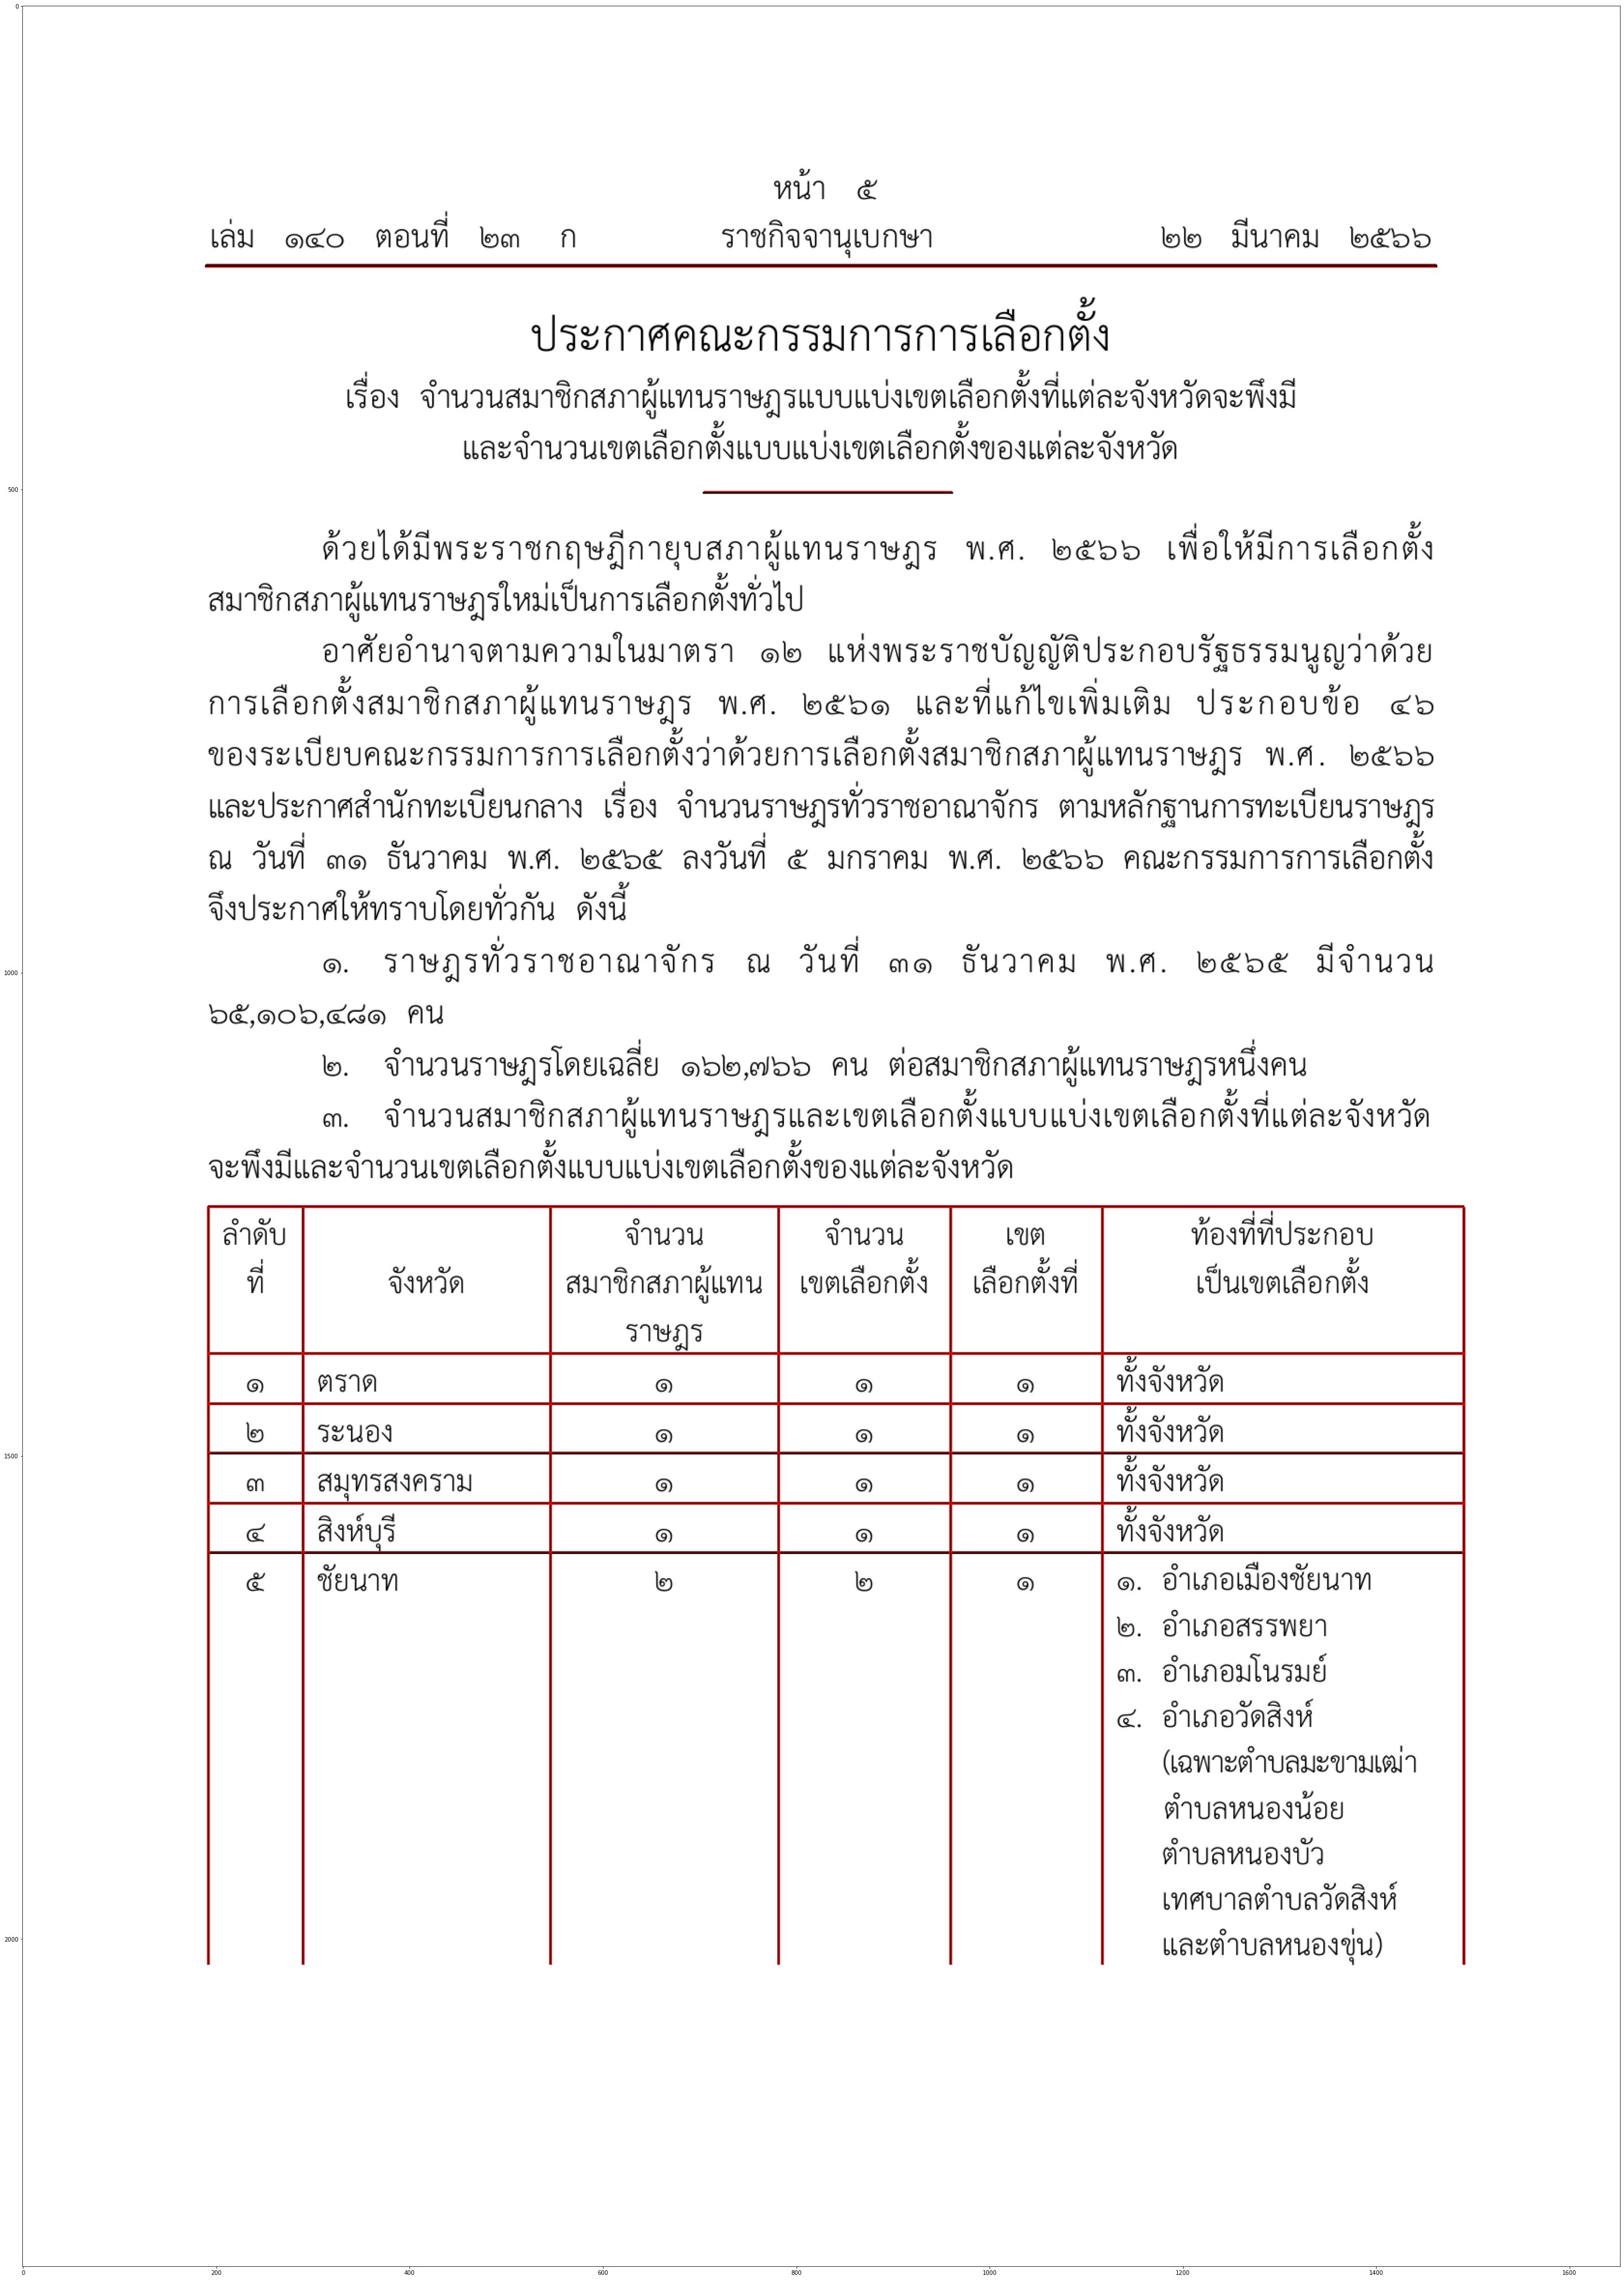

In [ ]:
im = cv2.imread("Constituencies/page0.png")
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
canny = cv2.Canny(im, 10, 200)
linesP = cv2.HoughLinesP(canny, 1, np.pi/180, 200, minLineLength=100, maxLineGap=3)
im = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)

for line in linesP:
    im = cv2.line(im, line[0][:2], line[0][2:], color = (255,0,0))

plt.figure(figsize = (50,100))
plt.imshow(im)
plt.show()

# Beyond OCR

In [2]:
import pandas as pd
import geopandas as gpd

pd.read_csv("Constituencies.csv")

c:\Users\kittapat.ra\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\kittapat.ra\AppData\Local\Temp\ipykernel_23600\1950402080.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapel

ลําดับที่      จังหวัด จํานวนสมาชิกสภาผู้แทนวาษฎว จํานวนเขตเลือกตั้ง  \
0           ๑         ตราด                          ๑                  ๑   
1           ๒        ระนอง                          ๑                  ๑   
2           ๓  สมุทรสงคราม                          ๑                  ๑   
3           ๔    สิงห์บุรี                          ๑                  ๑   
4           ๕       ชัยนาท                          ๒                  ๒   
..        ...          ...                        ...                ...   
446       NaN          NaN                        NaN                NaN   
447       NaN          NaN                        NaN                NaN   
448       NaN          NaN                        NaN                NaN   
449       NaN          NaN                        NaN                NaN   
450       NaN          NaN                        NaN                NaN   

    เขตเลือกตั้งที่                   ท้องที่ที่ประกอบเป็นเขตเลือกตั้ง  
0                 ๑                                        ทั้งจังหวัด  
1                 ๑                                        ทั้งจังหวัด  
2                 ๑                                        ทั้งจังหวัด  
3                 ๑                                        ทั้งจังหวัด  
4                 ๑  ๑. อําเภอเมืองชัยนาท ไ๒. อําเภอสรรพยา ณ๓. อําเ...  
..              ...                                                ...  
446             ๓๑๐  ๑๑. เขตบางแค (ยกเว้นแขวงบางแคเหนือ และแขวงบางไ...  
447             ๓๓๑  ๑. เขตทวีวัฒนา ๒. เขตตลิ่งชัน (ยกเว้นแขวงบางเช...  
448              ๓๒  ๑. เขตบางกอกบ้อย (เฉพาะแขวงศิริราช) ๒๒. เขตบาง...  
449             NaN  ๔. เขตตลิ่งชัน (เฉพาะแขวงบางเชือกหนัง) ๕ เขตธน...  
450           ดตาดา  ๑. เขตบางพลัด ๒. เขตบางกอกน้อย (ยกเว้นแขวงศิริ...  

[451 rows x 6 columns]

In [3]:
df = pd.read_csv("Constituencies.csv")
df["เขต"] = (~(df["เขตเลือกตั้งที่"].isna())).cumsum()
df = df.ffill()
df["ท้องที่ที่ประกอบเป็นเขตเลือกตั้ง"] = df["ท้องที่ที่ประกอบเป็นเขตเลือกตั้ง"].str[:] + " "
df = df.groupby(["จังหวัด", "เขต"], sort = False)["ท้องที่ที่ประกอบเป็นเขตเลือกตั้ง"].sum().str.strip()
df = df.reset_index()

df["shifted"] = df["จังหวัด"].eq(df["จังหวัด"].shift(1)).astype(int)
df["เขต"] = df.groupby("จังหวัด")["shifted"].cumsum() + 1
df = df[["จังหวัด", "เขต", "ท้องที่ที่ประกอบเป็นเขตเลือกตั้ง"]]
df

จังหวัด  เขต                   ท้องที่ที่ประกอบเป็นเขตเลือกตั้ง
0             ตราด    1                                        ทั้งจังหวัด
1            ระนอง    1                                        ทั้งจังหวัด
2      สมุทรสงคราม    1                                        ทั้งจังหวัด
3        สิงห์บุรี    1                                        ทั้งจังหวัด
4           ชัยนาท    1  ๑. อําเภอเมืองชัยนาท ไ๒. อําเภอสรรพยา ณ๓. อําเ...
..             ...  ...                                                ...
395  กรุงเทพมหานคร   29  ๑. เขตบางแค (เฉพาะแขวงบางแคเหนือ และแขวงบางไผ่...
396  กรุงเทพมหานคร   30  ๑๑. เขตบางแค (ยกเว้นแขวงบางแคเหนือ และแขวงบางไ...
397  กรุงเทพมหานคร   31  ๑. เขตทวีวัฒนา ๒. เขตตลิ่งชัน (ยกเว้นแขวงบางเช...
398  กรุงเทพมหานคร   32  ๑. เขตบางกอกบ้อย (เฉพาะแขวงศิริราช) ๒๒. เขตบาง...
399  กรุงเทพมหานคร   33  ๑. เขตบางพลัด ๒. เขตบางกอกน้อย (ยกเว้นแขวงศิริ...

[400 rows x 3 columns]

In [4]:
import difflib
actual = pd.read_csv("constuency_position.csv")
# actual[["จังหวัด", "จำนวนเขต"]]
df["จังหวัด"] = df["จังหวัด"].map(lambda x: difflib.get_close_matches(x, actual["จังหวัด"])[0])
actual_merged = actual.merge(df.groupby("จังหวัด").count()["เขต"].reset_index())
actual_merged["diff"] = actual_merged["จำนวนเขต"] - actual_merged["เขต"]
actual_merged[actual_merged["diff"] != 0]

Empty DataFrame
Columns: [order, จังหวัด, Province, จำนวนเขต, Unnamed: 4, เขต, diff]
Index: []

## Map Generation

In [224]:
import geopandas as gpd

col_change = {
    "ADM3_PCODE": "PAT_CODE",
    "ADM2_PCODE": "PA_CODE",
    "ADM1_PCODE": "P_CODE",
    "ADM3_TH": "T_NAME_TH",
    "ADM2_TH": "A_NAME_TH",
    "ADM1_TH": "P_NAME_TH",
    "ADM3_EN": "T_NAME_EN",
    "ADM2_EN": "A_NAME_EN",
    "ADM1_EN": "P_NAME_EN"
}

gdf_ref = gpd.read_file("PAT/tha_admbnda_adm3_rtsd_20220121.shp").rename(columns = col_change)
gdf_ref = gdf_ref[gdf_ref["P_NAME_TH"] != "กรุงเทพมหานคร"]
gdf_ref["PAT_CODE"] = gdf_ref["PAT_CODE"].str[2:]
gdf_ref["PA_CODE"] = gdf_ref["PA_CODE"].str[2:]
gdf_ref["P_CODE"] = gdf_ref["P_CODE"].str[2:]

col_bkk_change = {
    "SUBDISTRIC": "PAT_CODE",
    "DISTRICT_I": "PA_CODE",
    "CHANGWAT_I": "P_CODE",
    "SUBDISTR_1": "T_NAME_TH",
    "DISTRICT_N": "A_NAME_TH",
    "CHANGWAT_N": "P_NAME_TH"
}

bkk_shape = gpd.read_file("PAT_BKK/BMA_ADMIN_SUB_DISTRICT.shp")
bkk_shape["SUBDISTR_1"] = bkk_shape["SUBDISTR_1"].str.replace("แขวง", "")
bkk_shape["DISTRICT_N"] = bkk_shape["DISTRICT_N"].str.replace("บึ่งกุ่ม", "บึงกุ่ม")
bkk_shape["CHANGWAT_N"] = "กรุงเทพมหานคร"
bkk_shape = bkk_shape.to_crs(gdf_ref.crs).rename(columns = col_bkk_change)
gdf_ref = pd.concat([gdf_ref, bkk_shape], axis = 0)

gdf_ref[["PAT_CODE", "T_NAME_TH", "T_NAME_EN", "PA_CODE", "A_NAME_TH", "A_NAME_EN", "P_CODE", "P_NAME_TH", "P_NAME_EN", "validOn", "validTo", "geometry"]].to_file("new_datasets/PAT map (RTSD)/rtsd_pat.geojson", encoding = "utf-8")

In [195]:
gpd.read_file("new_datasets/PAT map (RTSD)/rtsd_pat.shp", encoding = "utf-8")

PAT_CODE   T_NAME_TH     T_NAME_EN PA_CODE         A_NAME_TH  \
0      110101      ปากน้ำ       Pak Nam    1101  เมืองสมุทรปราการ   
1      110102  สำโรงเหนือ  Samrong Nuea    1101  เมืองสมุทรปราการ   
2      110103    บางเมือง   Bang Mueang    1101  เมืองสมุทรปราการ   
3      110104    ท้ายบ้าน      Thai Ban    1101  เมืองสมุทรปราการ   
4      110108   บางปูใหม่   Bang Pu Mai    1101  เมืองสมุทรปราการ   
...       ...         ...           ...     ...               ...   
7431   103401     สวนหลวง          None    1034           สวนหลวง   
7432   104401    สะพานสูง          None    1044          สะพานสูง   
7433   104604  ทรายกองดิน          None    1046         คลองสามวา   
7434   104603      บางชัน          None    1046         คลองสามวา   
7435   103403    พัฒนาการ          None    1034           สวนหลวง   

                A_NAME_EN P_CODE      P_NAME_TH     P_NAME_EN     validOn  \
0     Mueang Samut Prakan     11    สมุทรปราการ  Samut Prakan  2022-01-22   
1     Mueang Samut Prakan     11    สมุทรปราการ  Samut Prakan  2022-01-22   
2     Mueang Samut Prakan     11    สมุทรปราการ  Samut Prakan  2022-01-22   
3     Mueang Samut Prakan     11    สมุทรปราการ  Samut Prakan  2022-01-22   
4     Mueang Samut Prakan     11    สมุทรปราการ  Samut Prakan  2022-01-22   
...                   ...    ...            ...           ...         ...   
7431                 None     10  กรุงเทพมหานคร          None        None   
7432                 None     10  กรุงเทพมหานคร          None        None   
7433                 None     10  กรุงเทพมหานคร          None        None   
7434                 None     10  กรุงเทพมหานคร          None        None   
7435                 None     10  กรุงเทพมหานคร          None        None   

     validTo                                           geometry  
0       None  POLYGON ((100.60612 13.57839, 100.60547 13.576...  
1       None  POLYGON ((100.60132 13.65703, 100.60281 13.656...  
2       None  POLYGON ((100.62934 13.62186, 100.63039 13.621...  
3       None  POLYGON ((100.62151 13.54063, 100.62072 13.540...  
4       None  POLYGON ((100.63229 13.55314, 100.63315 13.552...  
...      ...                                                ...  
7431    None  POLYGON ((100.61062 13.74381, 100.61106 13.743...  
7432    None  POLYGON ((100.67899 13.75202, 100.67889 13.752...  
7433    None  POLYGON ((100.76511 13.86884, 100.76508 13.868...  
7434    None  POLYGON ((100.72927 13.86400, 100.72928 13.863...  
7435    None  POLYGON ((100.63461 13.71501, 100.63455 13.715...  

[7436 rows x 12 columns]

In [185]:
bkk_shape

OBJECTID  AREA_CAL  AREA_BMA     PERIMETER  ADMIN_ID SUBDISTRIC  \
0           1    15.799    16.461  21537.211388         2     100608   
1           2    11.777    12.062  18260.517332         3     100601   
2           3    15.830    14.150  17831.192204         2     104003   
3           4    18.046    18.406  19142.466103         2     100502   
4           5    22.746    23.717  24066.164118         3     100508   
..        ...       ...       ...           ...       ...        ...   
175       183    24.354    23.678  24333.850658         1     103401   
176       184    27.980    28.124  25314.766414         1     104401   
177       189    10.509    11.396  15805.085868         3     104604   
178       194    20.131    18.644  23238.687635         5     104603   
179       195    24.354    23.678  24333.850658         1     103403   

     SUBDISTR_1 DISTRICT_I DISTRICT_N CHANGWAT_I   CHANGWAT_N    Shape_Leng  \
0       หัวหมาก       1006    บางกะปิ         10  กรุงเทพมหาน  21534.199039   
1      คลองจั่น       1006    บางกะปิ         10  กรุงเทพมหาน  18389.635298   
2        บางไผ่       1040      บางแค         10  กรุงเทพมหาน  17823.010749   
3    อนุสาวรีย์       1005     บางเขน         10  กรุงเทพมหาน  19100.682438   
4       ท่าแร้ง       1005     บางเขน         10  กรุงเทพมหาน  24034.908679   
..          ...        ...        ...        ...          ...           ...   
175     สวนหลวง       1034    สวนหลวง         10  กรุงเทพมหาน  15678.954227   
176    สะพานสูง       1044   สะพานสูง         10  กรุงเทพมหาน  11675.125307   
177  ทรายกองดิน       1046  คลองสามวา         10  กรุงเทพมหาน  16118.350474   
178      บางชัน       1046  คลองสามวา         10  กรุงเทพมหาน  23208.353511   
179    พัฒนาการ       1034    สวนหลวง         10  กรุงเทพมหาน  13283.081933   

       Shape_Area                                           geometry  
0    1.579931e+07  POLYGON ((100.66623 13.77219, 100.66630 13.772...  
1    1.177654e+07  POLYGON ((100.61507 13.79973, 100.61519 13.799...  
2    1.583048e+07  POLYGON ((100.35268 13.75202, 100.35269 13.752...  
3    1.804615e+07  POLYGON ((100.58653 13.85871, 100.58654 13.858...  
4    2.275052e+07  POLYGON ((100.64302 13.88546, 100.64303 13.885...  
..            ...                                                ...  
175  9.518943e+06  POLYGON ((100.61062 13.74381, 100.61106 13.743...  
176  8.089981e+06  POLYGON ((100.67899 13.75202, 100.67889 13.752...  
177  1.126509e+07  POLYGON ((100.76511 13.86884, 100.76508 13.868...  
178  2.013423e+07  POLYGON ((100.72927 13.86400, 100.72928 13.863...  
179  8.776473e+06  POLYGON ((100.63461 13.71501, 100.63455 13.715...  

[180 rows x 14 columns]

In [6]:
# gdf_ref[gdf_ref.A_NAME_T == "เมืองสมุทรปราการ"].replace("เทศบาลนครสมุทรปราการ", "ปากน้ำ").replace("เทศบาลบางปู", "บางปู")
a = gdf_ref.drop(columns = "geometry")

In [7]:
gdf_ref

Shape_Leng  Shape_Area       ADM3_EN    T_NAME_T PAT_CODE ADM3_REF  \
169     0.153685    0.000705       Pak Nam      ปากน้ำ   110101     None   
170     0.158108    0.000789  Samrong Nuea  สำโรงเหนือ   110102     None   
171     0.134400    0.000817   Bang Mueang    บางเมือง   110103     None   
172     0.145246    0.001165      Thai Ban    ท้ายบ้าน   110104     None   
173     0.313515    0.002527   Bang Pu Mai   บางปูใหม่   110108     None   
...          ...         ...           ...         ...      ...      ...   
7420    0.374400    0.004115   Phadung Mat    ผดุงมาตร   961203     None   
7421    1.022095    0.031049  Chang Phueak   ช้างเผือก   961204     None   
7422    0.355507    0.004813         Chuap         จวบ   961301     None   
7423    0.354100    0.005915        Bu Kit       บูกิต   961302     None   
7424    0.323695    0.005217   Marue Bo Ok  มะรือโบออก   961303     None   

     ADM3ALT1EN ADM3ALT2EN ADM3ALT1TH ADM3ALT2TH  ...       ADM1_EN  \
169        None       None       None       None  ...  Samut Prakan   
170        None       None       None       None  ...  Samut Prakan   
171        None       None       None       None  ...  Samut Prakan   
172        None       None       None       None  ...  Samut Prakan   
173        None       None       None       None  ...  Samut Prakan   
...         ...        ...        ...        ...  ...           ...   
7420       None       None       None       None  ...    Narathiwat   
7421       None       None       None       None  ...    Narathiwat   
7422       None       None       None       None  ...    Narathiwat   
7423       None       None       None       None  ...    Narathiwat   
7424       None       None       None       None  ...    Narathiwat   

         P_NAME_T P_CODE   ADM0_EN    ADM0_TH ADM0_PCODE        date  \
169   สมุทรปราการ     11  Thailand  ประเทศไทย         TH  2019-02-18   
170   สมุทรปราการ     11  Thailand  ประเทศไทย         TH  2019-02-18   
171   สมุทรปราการ     11  Thailand  ประเทศไทย         TH  2019-02-18   
172   สมุทรปราการ     11  Thailand  ประเทศไทย         TH  2019-02-18   
173   สมุทรปราการ     11  Thailand  ประเทศไทย         TH  2019-02-18   
...           ...    ...       ...        ...        ...         ...   
7420     นราธิวาส     96  Thailand  ประเทศไทย         TH  2019-02-18   
7421     นราธิวาส     96  Thailand  ประเทศไทย         TH  2019-02-18   
7422     นราธิวาส     96  Thailand  ประเทศไทย         TH  2019-02-18   
7423     นราธิวาส     96  Thailand  ประเทศไทย         TH  2019-02-18   
7424     นราธิวาส     96  Thailand  ประเทศไทย         TH  2019-02-18   

         validOn validTo                                           geometry  
169   2022-01-22    None  POLYGON ((100.60612 13.57839, 100.60547 13.576...  
170   2022-01-22    None  POLYGON ((100.60132 13.65703, 100.60281 13.656...  
171   2022-01-22    None  POLYGON ((100.62934 13.62186, 100.63039 13.621...  
172   2022-01-22    None  POLYGON ((100.62151 13.54063, 100.62072 13.540...  
173   2022-01-22    None  POLYGON ((100.63229 13.55314, 100.63315 13.552...  
...          ...     ...                                                ...  
7420  2022-01-22    None  POLYGON ((101.71127 6.17059, 101.71205 6.17043...  
7421  2022-01-22    None  POLYGON ((101.68554 6.08625, 101.68549 6.08545...  
7422  2022-01-22    None  POLYGON ((101.85236 6.29831, 101.85390 6.29768...  
7423  2022-01-22    None  POLYGON ((101.85688 6.22109, 101.85809 6.21962...  
7424  2022-01-22    None  POLYGON ((101.89718 6.29751, 101.89732 6.29668...  

[7256 rows x 23 columns]

In [74]:
municipal = gpd.read_file("Municipalities/Municipal - ขอบเขตเทศบาล.geojson")
municipal = municipal.to_crs(gdf_ref.crs)
municipal

OBJECTID DLA_CODE              DLA_NAME     DLA_TYPE AMP_ID   AMP_NAMT  \
0            1  1102402     เทศบาลตำบลคลองสวน   เทศบาลตำบล   1102     บางบ่อ   
1            2  1102403      เทศบาลตำบลบางบ่อ   เทศบาลตำบล   1102     บางบ่อ   
2            3  1102404  เทศบาลตำบลบางพลีน้อย   เทศบาลตำบล   1102     บางบ่อ   
3            4  1103401      เทศบาลตำบลบางพลี   เทศบาลตำบล   1103     บางพลี   
4            5  1104301    เทศบาลเมืองลัดหลวง  เทศบาลเมือง   1104  พระประแดง   
...        ...      ...                   ...          ...    ...        ...   
2211      2212  7208401      เทศบาลตำบลสามชุก   เทศบาลตำบล   7208     สามชุก   
2212      2213  7209401   เทศบาลตำบลสระยายโสม   เทศบาลตำบล   7209     อู่ทอง   
2213      2214  7209403      เทศบาลตำบลอู่ทอง   เทศบาลตำบล   7209     อู่ทอง   
2214      2215  7204401     เทศบาลตำบลโคกคราม   เทศบาลตำบล   7204  บางปลาม้า   
2215      2216  7204402   เทศบาลตำบลบางปลาม้า   เทศบาลตำบล   7204  บางปลาม้า   

     PROV_CODE    PROV_NAMT                                           geometry  
0           11  สมุทรปราการ  POLYGON ((100.93475 13.67020, 100.93450 13.670...  
1           11  สมุทรปราการ  POLYGON ((100.89791 13.64110, 100.89755 13.641...  
2           11  สมุทรปราการ  POLYGON ((100.90702 13.59173, 100.90695 13.592...  
3           11  สมุทรปราการ  POLYGON ((100.70812 13.68067, 100.70732 13.680...  
4           11  สมุทรปราการ  POLYGON ((100.53018 13.65328, 100.53020 13.653...  
...        ...          ...                                                ...  
2211        72   สุพรรณบุรี  POLYGON ((100.11676 14.78491, 100.11593 14.785...  
2212        72   สุพรรณบุรี  POLYGON ((99.90686 14.29956, 99.90469 14.29966...  
2213        72   สุพรรณบุรี  POLYGON ((99.91680 14.38866, 99.91504 14.38960...  
2214        72   สุพรรณบุรี  POLYGON ((100.20035 14.39310, 100.19957 14.394...  
2215        72   สุพรรณบุรี  POLYGON ((100.16505 14.39303, 100.16480 14.394...  

[2216 rows x 9 columns]

In [9]:
bkk_shape = gpd.read_file("PAT_BKK/BMA_ADMIN_SUB_DISTRICT.shp")
bkk_shape["SUBDISTR_1"] = bkk_shape["SUBDISTR_1"].str.replace("แขวง", "")
bkk_shape["DISTRICT_N"] = bkk_shape["DISTRICT_N"].str.replace("บึ่งกุ่ม", "บึงกุ่ม")
bkk_shape = bkk_shape.to_crs(gdf_ref.crs)

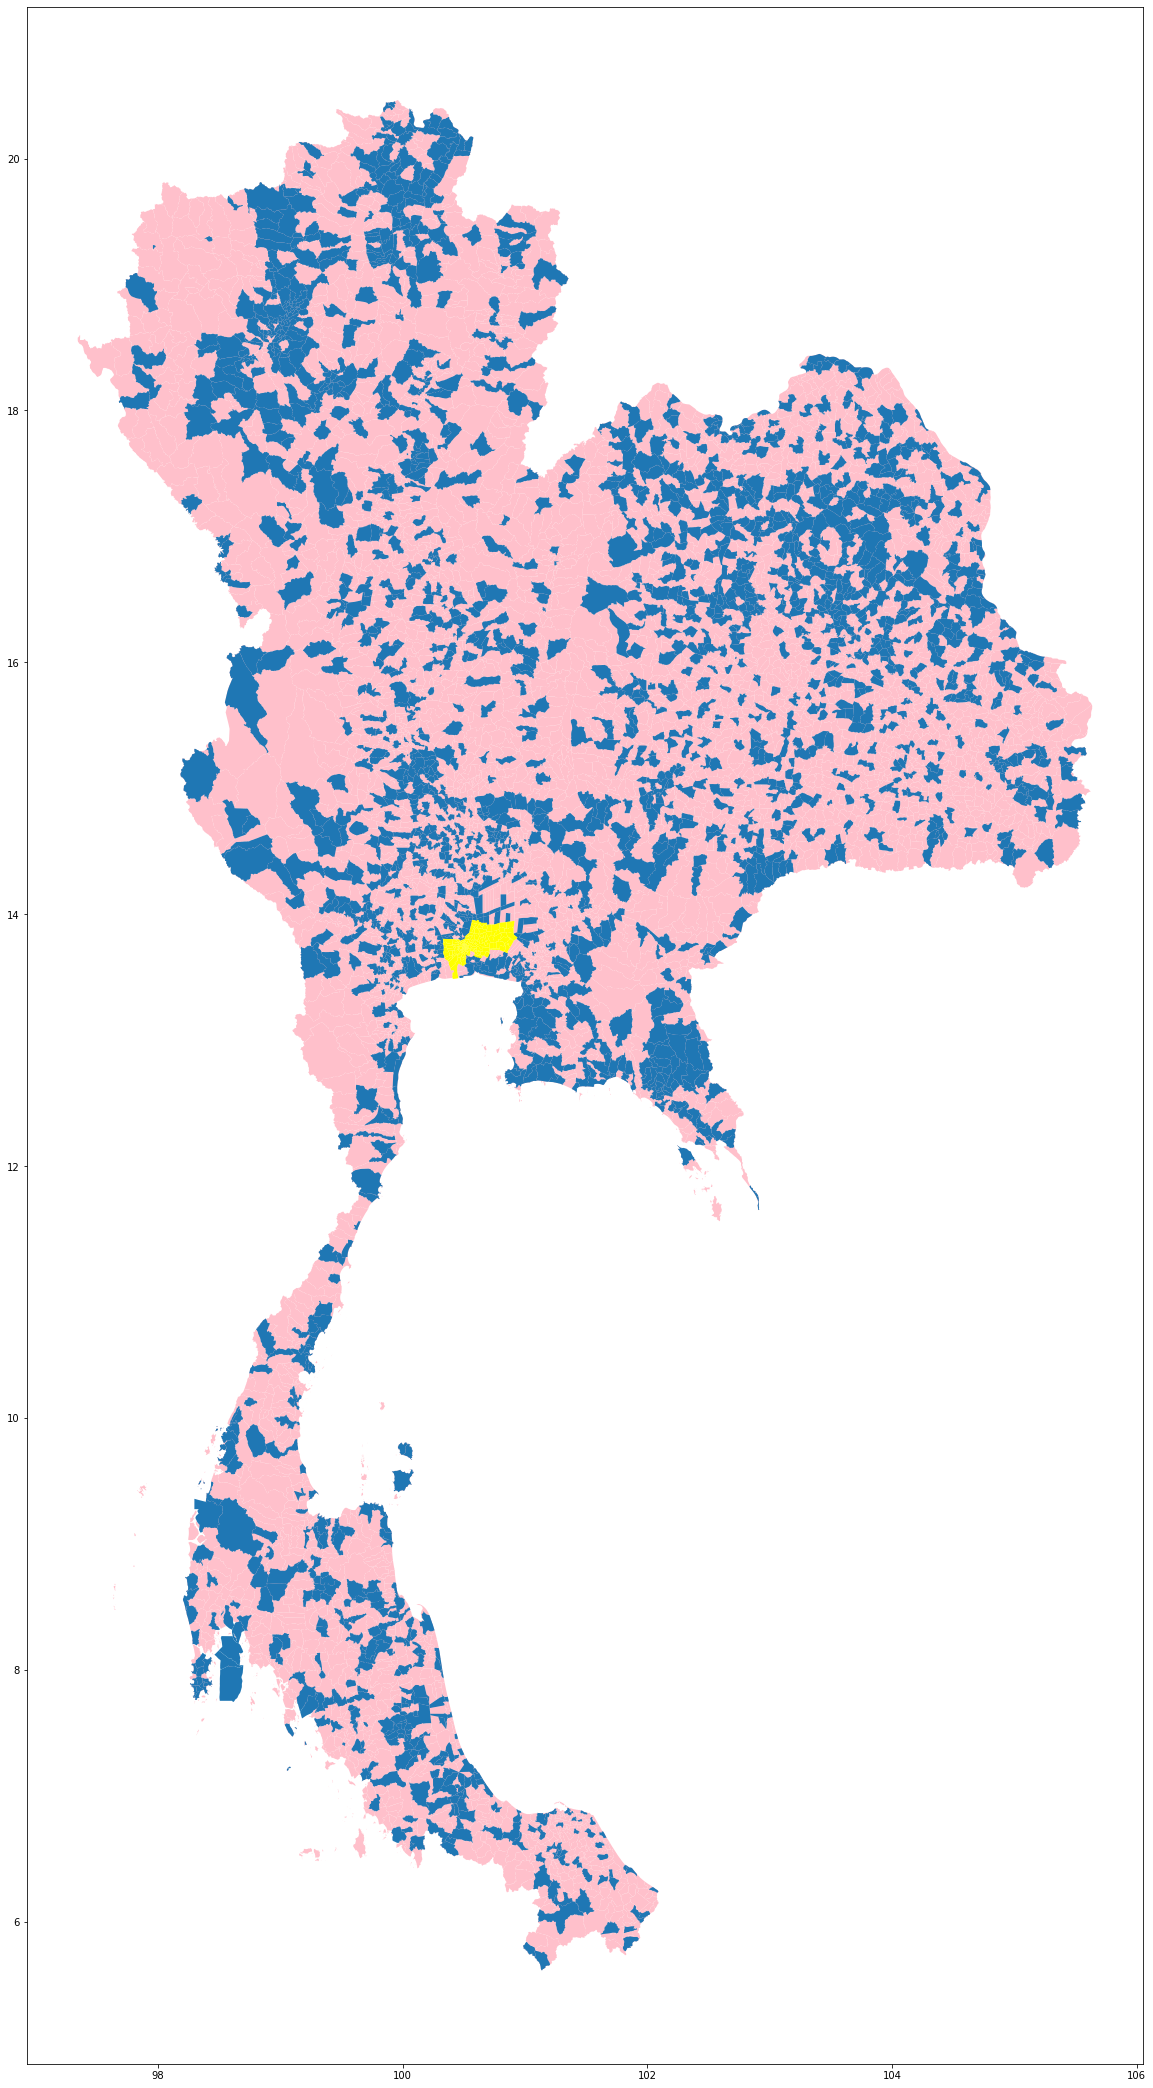

In [75]:
f, ax = plt.subplots(figsize = (20, 40))
gdf_ref.plot(ax = ax, color = "pink")
municipal.plot(ax = ax)
bkk_shape.plot(ax = ax, color = "yellow")
plt.show()

## Resolving table

In [11]:
def remove_none(x):
    x_prime = []
    for y in x:
        if y != "":
            x_prime.append(y)
    return x_prime

dg = df.copy()
dg["ท้องที่ที่ประกอบเป็นเขตเลือกตั้ง"] = dg["ท้องที่ที่ประกอบเป็นเขตเลือกตั้ง"].str.split("""(?= เขต[^\s])|(?=อำเภอ|อาเภอ)|^\S{,2}[\. ]| [^\s'”]{,2}[\. ]|[๐๑๒๓๔๕๖๗๘๙0123456789]\.+ |ดตา\. """).apply(remove_none)
dg = dg.explode("ท้องที่ที่ประกอบเป็นเขตเลือกตั้ง")
dg["อำเภอ"] = dg["ท้องที่ที่ประกอบเป็นเขตเลือกตั้ง"].apply(lambda x: x.split()[0])
dg["ตำบล"] = dg["ท้องที่ที่ประกอบเป็นเขตเลือกตั้ง"].apply(lambda x: " ".join(x.split()[1:])[1:-1])

dg

จังหวัด  เขต                   ท้องที่ที่ประกอบเป็นเขตเลือกตั้ง  \
0             ตราด    1                                        ทั้งจังหวัด   
1            ระนอง    1                                        ทั้งจังหวัด   
2      สมุทรสงคราม    1                                        ทั้งจังหวัด   
3        สิงห์บุรี    1                                        ทั้งจังหวัด   
4           ชัยนาท    1                                  อําเภอเมืองชัยนาท   
..             ...  ...                                                ...   
398  กรุงเทพมหานคร   32  เขตภาษีเจริญ (ยกเว้นแขวงบางหว้า แขวงบางด้วน ' ...   
398  กรุงเทพมหานคร   32                เขตตลิ่งชัน (เฉพาะแขวงบางเชือกหนัง)   
398  กรุงเทพมหานคร   32  เขตธนบุรี (เฉพาะแขวงวัดกัลยาณ์ แขวงหิรัญรูจ แล...   
399  กรุงเทพมหานคร   33                                         เขตบางพลัด   
399  กรุงเทพมหานคร   33                  เขตบางกอกน้อย (ยกเว้นแขวงศิริราช)   

                 อำเภอ                                               ตำบล  
0          ทั้งจังหวัด                                                     
1          ทั้งจังหวัด                                                     
2          ทั้งจังหวัด                                                     
3          ทั้งจังหวัด                                                     
4    อําเภอเมืองชัยนาท                                                     
..                 ...                                                ...  
398       เขตภาษีเจริญ    ยกเว้นแขวงบางหว้า แขวงบางด้วน ' และแขวงคลองขวาง  
398        เขตตลิ่งชัน                              เฉพาะแขวงบางเชือกหนัง  
398          เขตธนบุรี  เฉพาะแขวงวัดกัลยาณ์ แขวงหิรัญรูจ และแขวงบางยี่...  
399         เขตบางพลัด                                                     
399      เขตบางกอกน้อย                                  ยกเว้นแขวงศิริราช  

[1136 rows x 5 columns]

In [12]:
def tesaban_concat(x):
    y = []
    tesaban = []
    tesaban_bool = False
    parenthesis_bool = False
    for idx in range(len(x)):
        if (x[idx].strip() == "เทศบาล") and (not(parenthesis_bool)):
            tesaban.append(x[idx].strip())
            tesaban_bool = True
        elif tesaban_bool:
            tesaban.append(x[idx].strip())
            if not(parenthesis_bool):
                if x[idx].strip() != "":
                    if x[idx].strip()[-1] == "(":
                        parenthesis_bool = True
                    else:
                        y.append("".join(tesaban))
                        tesaban = []
                        tesaban_bool = False
            else:
                if x[idx].strip() != "":
                    if x[idx].strip()[-1] == ")":
                        parenthesis_bool = False
                        y.append("".join(tesaban))
                        tesaban = []
                        tesaban_bool = False
                    else:
                        continue
        else:
            if x[idx].strip() != "":
                if (x[idx].strip()[-1] != "(") and (tesaban == []):
                    y.append(x[idx].strip())
                elif not(parenthesis_bool):
                    tesaban.append(x[idx].strip())
                    parenthesis_bool = True
                else:
                    if x[idx].strip() != "":
                        tesaban.append(x[idx].strip())
                        if x[idx].strip()[-1] == ")":
                            y.append("".join(tesaban))
                            tesaban = []
                            parenthesis_bool = False
    return y

def split_tesaban(x):
    y = []
    if type(x) == str:
        x_new = re.sub("\(|\)| ", "", x)
        x_arr = re.split("(?=เทศบาล)", x_new)
        for element in x_arr:
            if re.findall("เทศบาล", element) == []:
                
                if element.strip() != "":
                    y += remove_none(re.split("ตำบล|ตาบล|ตําบล", element))
            else:
                y.append(element.strip())
        return y
    else:
        return x

dgg = dg[["จังหวัด", "เขต", "อำเภอ", "ตำบล"]]
dgg["ตำบล"] = dgg["ตำบล"].str.split("(?=แขวง)|(?=ตำบล|ตาบล|ตําบล)|(?=เทศบาล)|และ").apply(remove_none)
dgg["flag"] = dgg["ตำบล"].str[0].apply(lambda x: difflib.get_close_matches(x, ["เฉพาะ", "ยกเว้น"]) if type(x) not in [float, int] else np.nan).str[0]
dgg["ตำบล"] = dgg.apply(lambda x: x["ตำบล"][1:] if type(x.flag) == str else x["ตำบล"], axis = 1).apply(tesaban_concat)
dgg["อำเภอ"] = dgg["อำเภอ"].apply(lambda x: np.nan if x == "ทั้งจังหวัด" else re.sub("อำเภอ|อําเภอ|อาเภอ|เขต", "", x))
dgg = dgg.explode("ตำบล")
dgg["ตำบล"] = dgg["ตำบล"].apply(lambda x: x if ((type(x) != str) or (re.findall("เทศบาล", x) != [])) else re.sub("แขวง|ตาบล|ตำบล|ตําบล", "", x))
dgg["optional"] = dgg["ตำบล"].str.split("\(").str[1].apply(split_tesaban)
dgg["ตำบล"] = dgg["ตำบล"].str.split("\(").str[0].apply(lambda x: x if ((type(x) != str) or (re.findall("เทศบาล", x) != [])) else re.sub("แขวง|ตาบล|ตำบล|ตําบล", "",x))
dgg = dgg.explode("optional")

dgg

C:\Users\kittapat.ra\AppData\Local\Temp\ipykernel_23600\3313123294.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dgg["ตำบล"] = dgg["ตำบล"].str.split("(?=แขวง)|(?=ตำบล|ตาบล|ตําบล)|(?=เทศบาล)|และ").apply(remove_none)


จังหวัด  เขต        อำเภอ        ตำบล    flag optional
0             ตราด    1          NaN         NaN     NaN      NaN
1            ระนอง    1          NaN         NaN     NaN      NaN
2      สมุทรสงคราม    1          NaN         NaN     NaN      NaN
3        สิงห์บุรี    1          NaN         NaN     NaN      NaN
4           ชัยนาท    1  เมืองชัยนาท         NaN     NaN      NaN
..             ...  ...          ...         ...     ...      ...
398  กรุงเทพมหานคร   32       ธนบุรี  วัดกัลยาณ์   เฉพาะ      NaN
398  กรุงเทพมหานคร   32       ธนบุรี    หิรัญรูจ   เฉพาะ      NaN
398  กรุงเทพมหานคร   32       ธนบุรี  บางยี่เรือ   เฉพาะ      NaN
399  กรุงเทพมหานคร   33      บางพลัด         NaN     NaN      NaN
399  กรุงเทพมหานคร   33   บางกอกน้อย     ศิริราช  ยกเว้น      NaN

[2185 rows x 6 columns]

In [13]:
def sub_amphoe(x):
    if type(x["อำเภอ"]) == str:
        if x["จังหวัด"] != "กรุงเทพมหานคร":   
            focused = adm_df[adm_df.P_NAME_T == x["จังหวัด"]]
            result = difflib.get_close_matches(x["อำเภอ"], focused.A_NAME_T)
        else:
            result = difflib.get_close_matches(x["อำเภอ"], adm_bkk.DISTRICT_N)
        if result != []:
            return result[0]
        else:
            return np.nan
    else:
        return x["อำเภอ"]
    
def sub_tambon(x, optional = False):
    if optional: tb = "optional"
    else: tb = "ตำบล"
    if type(x[tb]) == str:
        if re.findall("เทศบาล", x[tb]) != []:
            result = difflib.get_close_matches(x[tb], adm_mun.NAMT)
        elif x["จังหวัด"] != "กรุงเทพมหานคร":
            focused = adm_df[(adm_df.P_NAME_T == x["จังหวัด"]) & (adm_df.A_NAME_T == x["อำเภอ"])]
            result = difflib.get_close_matches(x[tb], focused.T_NAME_T)
        else:
            focused = adm_bkk[(adm_bkk.DISTRICT_N == x["อำเภอ"])]
            result = difflib.get_close_matches(x[tb], focused.SUBDISTR_1)
        if result != []:
            return result[0]
        else:
            return np.nan

adm_df = gdf_ref[["P_NAME_T", "A_NAME_T", "T_NAME_T"]]
adm_bkk = bkk_shape[["DISTRICT_N", "SUBDISTR_1"]]
adm_mun = municipal[["NAMT"]]
last_dgg = dgg.copy()
last_dgg["อำเภอ"] = last_dgg.apply(sub_amphoe, axis = 1)
last_dgg["ตำบล"] = last_dgg.apply(sub_tambon, axis = 1)
last_dgg["optional"] = last_dgg.apply(sub_tambon, optional = True, axis = 1)

last_dgg

จังหวัด  เขต        อำเภอ        ตำบล    flag optional
0             ตราด    1          NaN        None     NaN     None
1            ระนอง    1          NaN        None     NaN     None
2      สมุทรสงคราม    1          NaN        None     NaN     None
3        สิงห์บุรี    1          NaN        None     NaN     None
4           ชัยนาท    1  เมืองชัยนาท        None     NaN     None
..             ...  ...          ...         ...     ...      ...
398  กรุงเทพมหานคร   32       ธนบุรี  วัดกัลยาณ์   เฉพาะ     None
398  กรุงเทพมหานคร   32       ธนบุรี   หิรัญรูจี   เฉพาะ     None
398  กรุงเทพมหานคร   32       ธนบุรี  บางยี่เรือ   เฉพาะ     None
399  กรุงเทพมหานคร   33      บางพลัด        None     NaN     None
399  กรุงเทพมหานคร   33   บางกอกน้อย     ศิริราช  ยกเว้น     None

[2185 rows x 6 columns]

## Agreement checking

In [14]:
check_dgg = pd.concat([last_dgg.rename(columns = {"ตำบล": "ตำบล_1", "optional": "optional_1"}), dgg], axis = 1)
check_dgg[(check_dgg["ตำบล_1"].isnull() & ~(check_dgg["ตำบล"].isna())) | (check_dgg["optional_1"].isnull() & ~(check_dgg["optional"].isna()))]

Empty DataFrame
Columns: [จังหวัด, เขต, อำเภอ, ตำบล_1, flag, optional_1, จังหวัด, เขต, อำเภอ, ตำบล, flag, optional]
Index: []

In [69]:
municipal_code = pd.read_excel("Municipalities/ตารางแสดงรหัส-อปท-ปีงบประมาณ-2562.xlsx")
municipal_code["ชื่ออปท."] = municipal_code["ชื่ออปท."].str.replace(" |องค์กรปกครองท้องถิ่นรูปแบบพิเศษ", "")
municipal_code

C:\Users\kittapat.ra\AppData\Local\Temp\ipykernel_23600\3840554079.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  municipal_code["ชื่ออปท."] = municipal_code["ชื่ออปท."].str.replace(" |องค์กรปกครองท้องถิ่นรูปแบบพิเศษ", "")


รหัสอปท.                        ชื่ออปท.          อำเภอ        จังหวัด
0       100001                   กรุงเทพมหานคร            NaN  กรุงเทพมหานคร
1      1200401                      เมืองพัทยา       บางละมุง         ชลบุรี
2      2810101  องค์การบริหารส่วนจังหวัดกระบี่    เมืองกระบี่         กระบี่
3      4810102               เทศบาลเมืองกระบี่    เมืองกระบี่         กระบี่
4      5810109            เทศบาลตำบลกระบี่น้อย    เมืองกระบี่         กระบี่
...        ...                             ...            ...            ...
7847   6342402   องค์การบริหารส่วนตำบลเหล่าแดง       ดอนมดแดง    อุบลราชธานี
7848   6341408    องค์การบริหารส่วนตำบลเหล่าบก     ม่วงสามสิบ    อุบลราชธานี
7849   6341118   องค์การบริหารส่วนตำบลไหล่ทุ่ง    ตระการพืชผล    อุบลราชธานี
7850   6341915   องค์การบริหารส่วนตำบลอ่างศิลา  พิบูลมังสาหาร    อุบลราชธานี
7851   6340206  องค์การบริหารส่วนตำบลเอือดใหญ่   ศรีเมืองใหม่    อุบลราชธานี

[7852 rows x 4 columns]

In [83]:
municipal[municipal["DLA_CODE"]=="1803401"]

OBJECTID DLA_CODE            DLA_NAME    DLA_TYPE AMP_ID  AMP_NAMT  \
180       181  1803401  เทศบาลตำบลวัดสิงห์  เทศบาลตำบล   1803  วัดสิงห์   

    PROV_CODE PROV_NAMT                                           geometry  
180        18    ชัยนาท  POLYGON ((100.04805 15.26481, 100.04794 15.265...

## Finalé

In [65]:
municipal_map

รหัสอปท.                 ชื่ออปท.                     name  \
0       100001            กรุงเทพมหานคร            กรุงเทพมหานคร   
1      5770104           เทศบาลตำบลกม.5           เทศบาลตำบลกม.5   
2      5850402         เทศบาลตำบลจ.ป.ร.         เทศบาลตำบลจ.ป.ร.   
3      5451202          เทศบาลตำบลกกกุง          เทศบาลตำบลกกกุง   
4      5490403          เทศบาลตำบลกกตูม          เทศบาลตำบลกกตูม   
...        ...                      ...                      ...   
2416   4200103        เทศบาลเมืองแสนสุข        เทศบาลเมืองแสนสุข   
2417   4410103  เทศบาลเมืองโนนสูง-น้ำคำ  เทศบาลเมืองโนนสูง-น้ำคำ   
2418   4700701       เทศบาลเมืองโพธาราม       เทศบาลเมืองโพธาราม   
2419   4730601        เทศบาลเมืองไร่ขิง        เทศบาลเมืองไร่ขิง   
2420   1200401               เมืองพัทยา               เมืองพัทยา   

                     อำเภอ          จังหวัด  \
0                      NaN    กรุงเทพมหานคร   
1     เมืองประจวบคีรีขันธ์  ประจวบคีรีขันธ์   
2                  กระบุรี            ระนอง   
3                เมืองสรวง         ร้อยเอ็ด   
4                   ดงหลวง         มุกดาหาร   
...                    ...              ...   
2416           เมืองชลบุรี           ชลบุรี   
2417         เมืองอุดรธานี         อุดรธานี   
2418               โพธาราม          ราชบุรี   
2419               สามพราน           นครปฐม   
2420              บางละมุง           ชลบุรี   

                                               geometry  
0     POLYGON ((100.87883 13.73788, 100.87910 13.738...  
1     POLYGON ((99.79284 11.90209, 99.79073 11.90352...  
2     POLYGON ((98.88020 10.78834, 98.87990 10.78876...  
3     POLYGON ((103.77883 15.79559, 103.77671 15.796...  
4     POLYGON ((104.19909 16.66002, 104.19933 16.660...  
...                                                 ...  
2416  POLYGON ((100.90337 13.31713, 100.90335 13.317...  
2417  POLYGON ((102.87933 17.27044, 102.88478 17.273...  
2418  POLYGON ((99.84981 13.70131, 99.84980 13.70128...  
2419  POLYGON ((100.30911 13.74697, 100.30850 13.747...  
2420  POLYGON ((100.93115 12.99739, 100.93122 12.997...  

[2421 rows x 6 columns]

In [19]:
bkk_shape

OBJECTID  AREA_CAL  AREA_BMA     PERIMETER  ADMIN_ID SUBDISTRIC  \
0           1    15.799    16.461  21537.211388         2     100608   
1           2    11.777    12.062  18260.517332         3     100601   
2           3    15.830    14.150  17831.192204         2     104003   
3           4    18.046    18.406  19142.466103         2     100502   
4           5    22.746    23.717  24066.164118         3     100508   
..        ...       ...       ...           ...       ...        ...   
175       183    24.354    23.678  24333.850658         1     103401   
176       184    27.980    28.124  25314.766414         1     104401   
177       189    10.509    11.396  15805.085868         3     104604   
178       194    20.131    18.644  23238.687635         5     104603   
179       195    24.354    23.678  24333.850658         1     103403   

     SUBDISTR_1 DISTRICT_I DISTRICT_N CHANGWAT_I   CHANGWAT_N    Shape_Leng  \
0       หัวหมาก       1006    บางกะปิ         10  กรุงเทพมหาน  21534.199039   
1      คลองจั่น       1006    บางกะปิ         10  กรุงเทพมหาน  18389.635298   
2        บางไผ่       1040      บางแค         10  กรุงเทพมหาน  17823.010749   
3    อนุสาวรีย์       1005     บางเขน         10  กรุงเทพมหาน  19100.682438   
4       ท่าแร้ง       1005     บางเขน         10  กรุงเทพมหาน  24034.908679   
..          ...        ...        ...        ...          ...           ...   
175     สวนหลวง       1034    สวนหลวง         10  กรุงเทพมหาน  15678.954227   
176    สะพานสูง       1044   สะพานสูง         10  กรุงเทพมหาน  11675.125307   
177  ทรายกองดิน       1046  คลองสามวา         10  กรุงเทพมหาน  16118.350474   
178      บางชัน       1046  คลองสามวา         10  กรุงเทพมหาน  23208.353511   
179    พัฒนาการ       1034    สวนหลวง         10  กรุงเทพมหาน  13283.081933   

       Shape_Area                                           geometry  
0    1.579931e+07  POLYGON ((100.66623 13.77219, 100.66630 13.772...  
1    1.177654e+07  POLYGON ((100.61507 13.79973, 100.61519 13.799...  
2    1.583048e+07  POLYGON ((100.35268 13.75202, 100.35269 13.752...  
3    1.804615e+07  POLYGON ((100.58653 13.85871, 100.58654 13.858...  
4    2.275052e+07  POLYGON ((100.64302 13.88546, 100.64303 13.885...  
..            ...                                                ...  
175  9.518943e+06  POLYGON ((100.61062 13.74381, 100.61106 13.743...  
176  8.089981e+06  POLYGON ((100.67899 13.75202, 100.67889 13.752...  
177  1.126509e+07  POLYGON ((100.76511 13.86884, 100.76508 13.868...  
178  2.013423e+07  POLYGON ((100.72927 13.86400, 100.72928 13.863...  
179  8.776473e+06  POLYGON ((100.63461 13.71501, 100.63455 13.715...  

[180 rows x 14 columns]

In [20]:
gdf_ref

Shape_Leng  Shape_Area       ADM3_EN    T_NAME_T PAT_CODE ADM3_REF  \
169     0.153685    0.000705       Pak Nam      ปากน้ำ   110101     None   
170     0.158108    0.000789  Samrong Nuea  สำโรงเหนือ   110102     None   
171     0.134400    0.000817   Bang Mueang    บางเมือง   110103     None   
172     0.145246    0.001165      Thai Ban    ท้ายบ้าน   110104     None   
173     0.313515    0.002527   Bang Pu Mai   บางปูใหม่   110108     None   
...          ...         ...           ...         ...      ...      ...   
7420    0.374400    0.004115   Phadung Mat    ผดุงมาตร   961203     None   
7421    1.022095    0.031049  Chang Phueak   ช้างเผือก   961204     None   
7422    0.355507    0.004813         Chuap         จวบ   961301     None   
7423    0.354100    0.005915        Bu Kit       บูกิต   961302     None   
7424    0.323695    0.005217   Marue Bo Ok  มะรือโบออก   961303     None   

     ADM3ALT1EN ADM3ALT2EN ADM3ALT1TH ADM3ALT2TH  ...       ADM1_EN  \
169        None       None       None       None  ...  Samut Prakan   
170        None       None       None       None  ...  Samut Prakan   
171        None       None       None       None  ...  Samut Prakan   
172        None       None       None       None  ...  Samut Prakan   
173        None       None       None       None  ...  Samut Prakan   
...         ...        ...        ...        ...  ...           ...   
7420       None       None       None       None  ...    Narathiwat   
7421       None       None       None       None  ...    Narathiwat   
7422       None       None       None       None  ...    Narathiwat   
7423       None       None       None       None  ...    Narathiwat   
7424       None       None       None       None  ...    Narathiwat   

         P_NAME_T P_CODE   ADM0_EN    ADM0_TH ADM0_PCODE        date  \
169   สมุทรปราการ     11  Thailand  ประเทศไทย         TH  2019-02-18   
170   สมุทรปราการ     11  Thailand  ประเทศไทย         TH  2019-02-18   
171   สมุทรปราการ     11  Thailand  ประเทศไทย         TH  2019-02-18   
172   สมุทรปราการ     11  Thailand  ประเทศไทย         TH  2019-02-18   
173   สมุทรปราการ     11  Thailand  ประเทศไทย         TH  2019-02-18   
...           ...    ...       ...        ...        ...         ...   
7420     นราธิวาส     96  Thailand  ประเทศไทย         TH  2019-02-18   
7421     นราธิวาส     96  Thailand  ประเทศไทย         TH  2019-02-18   
7422     นราธิวาส     96  Thailand  ประเทศไทย         TH  2019-02-18   
7423     นราธิวาส     96  Thailand  ประเทศไทย         TH  2019-02-18   
7424     นราธิวาส     96  Thailand  ประเทศไทย         TH  2019-02-18   

         validOn validTo                                           geometry  
169   2022-01-22    None  POLYGON ((100.60612 13.57839, 100.60547 13.576...  
170   2022-01-22    None  POLYGON ((100.60132 13.65703, 100.60281 13.656...  
171   2022-01-22    None  POLYGON ((100.62934 13.62186, 100.63039 13.621...  
172   2022-01-22    None  POLYGON ((100.62151 13.54063, 100.62072 13.540...  
173   2022-01-22    None  POLYGON ((100.63229 13.55314, 100.63315 13.552...  
...          ...     ...                                                ...  
7420  2022-01-22    None  POLYGON ((101.71127 6.17059, 101.71205 6.17043...  
7421  2022-01-22    None  POLYGON ((101.68554 6.08625, 101.68549 6.08545...  
7422  2022-01-22    None  POLYGON ((101.85236 6.29831, 101.85390 6.29768...  
7423  2022-01-22    None  POLYGON ((101.85688 6.22109, 101.85809 6.21962...  
7424  2022-01-22    None  POLYGON ((101.89718 6.29751, 101.89732 6.29668...  

[7256 rows x 23 columns]

In [21]:
last_dgg

จังหวัด  เขต        อำเภอ        ตำบล    flag optional
0             ตราด    1          NaN        None     NaN     None
1            ระนอง    1          NaN        None     NaN     None
2      สมุทรสงคราม    1          NaN        None     NaN     None
3        สิงห์บุรี    1          NaN        None     NaN     None
4           ชัยนาท    1  เมืองชัยนาท        None     NaN     None
..             ...  ...          ...         ...     ...      ...
398  กรุงเทพมหานคร   32       ธนบุรี  วัดกัลยาณ์   เฉพาะ     None
398  กรุงเทพมหานคร   32       ธนบุรี   หิรัญรูจี   เฉพาะ     None
398  กรุงเทพมหานคร   32       ธนบุรี  บางยี่เรือ   เฉพาะ     None
399  กรุงเทพมหานคร   33      บางพลัด        None     NaN     None
399  กรุงเทพมหานคร   33   บางกอกน้อย     ศิริราช  ยกเว้น     None

[2185 rows x 6 columns]

In [97]:
municipal2 = gpd.read_file("Municipalities/เทศบาล.geojson")
municipal2 = municipal2.to_crs(gdf_ref.crs)
municipal2

objectid_1  objectid     id                      name  \
0              1         1  11128          เทศบาลตำบลขัวมุง   
1              2         2    298  เทศบาลตำบลขาณุวรลักษบุรี   
2              3         3    514       เทศบาลตำบลขามทะเลสอ   
3              4         4  12480         เทศบาลตำบลขามป้อม   
4              5         5  12392        เทศบาลตำบลขามเรียง   
...          ...       ...    ...                       ...   
2481        2482      2482  12955         เทศบาลตำบลป่าคลอก   
2482        2483      2483  12956             กรุงเทพมหานคร   
2483        2484      2484  12957           เทศบาลตำบลเวียง   
2484        2485      2485   2123          เทศบาลตำบลป่าสัก   
2485        2486      2486     40          เทศบาลตำบลปากน้ำ   

                            name_eng  type  pop_year  population     male  \
0             KHUA MUNG MUNICIPALITY     3      2017        5514     2643   
1     KHANU WORALAKBURI MUNICIPALITY     3      2017        8371     4052   
2         KHAM THALE SO MUNICIPALITY     3      2017        4283     2129   
3              KHAM POM MUNICIPALITY     3      2017        9422     4781   
4            KHAM RIANG MUNICIPALITY     3      2017       16430     6533   
...                              ...   ...       ...         ...      ...   
2481           PA KHLOK MUNICIPALITY     3      2017       16441     8007   
2482            BANGKOK METROPOLITAN     1      2017     5682415  2682962   
2483              WIANG MUNICIPALITY     3      2017        5590     2694   
2484             PA SAK MUNICIPALITY     3      2017       13828     6633   
2485            PAK NAM MUNICIPALITY     3      2017        2678     1409   

       female    house   version     shape_leng  \
0        2871     2281  2018-30N   15961.676652   
1        4319     3299  2018-30N   16827.780414   
2        2154     1993  2018-30N    9007.542686   
3        4641     2994  2018-30N   40882.389561   
4        9897     5027  2018-30N   39224.567212   
...       ...      ...       ...            ...   
2481     8434     8307  2018-30N     420.890088   
2482  2999453  2887274  2018-30N  264294.490985   
2483     2896     2197  2018-30N   16329.767843   
2484     7195     6803  2018-30N   39827.062052   
2485     1269     1734  2018-30N    6225.885937   

                                               geometry  
0     POLYGON ((98.99462 18.68672, 98.99431 18.68677...  
1     POLYGON ((99.85984 16.07773, 99.85960 16.07799...  
2     POLYGON ((101.95638 14.94751, 101.95650 14.947...  
3     POLYGON ((105.24035 16.00310, 105.23908 16.003...  
4     POLYGON ((103.27518 16.28164, 103.27513 16.281...  
...                                                 ...  
2481  POLYGON ((98.42901 7.99057, 98.42902 7.99059, ...  
2482  POLYGON ((100.87883 13.73788, 100.87910 13.738...  
2483  POLYGON ((100.32827 19.51088, 100.32818 19.510...  
2484  POLYGON ((99.04540 18.56245, 99.04522 18.56246...  
2485  POLYGON ((98.60122 9.94585, 98.59910 9.95614, ...  

[2486 rows x 14 columns]

In [123]:
province = gpd.read_file("PAT/tha_admbnda_adm2_rtsd_20220121.shp")
province

Shape_Leng  Shape_Area        ADM2_EN     ADM2_TH ADM2_PCODE ADM2_REF  \
0      0.085417    0.000450    Phra Nakhon      พระนคร     TH1001     None   
1      0.134132    0.000950          Dusit       ดุสิต     TH1002     None   
2      0.676342    0.019859      Nong Chok     หนองจอก     TH1003     None   
3      0.085886    0.000337       Bang Rak      บางรัก     TH1004     None   
4      0.301722    0.003415      Bang Khen      บางเขน     TH1005     None   
..          ...         ...            ...         ...        ...      ...   
923    1.288659    0.042957       Sukhirin     สุคิริน     TH9609     None   
924    0.551915    0.010903  Su-Ngai Kolok  สุไหงโก-ลก     TH9610     None   
925    0.982590    0.031559   Su-Ngai Padi   สุไหงปาดี     TH9611     None   
926    1.403064    0.048271         Chanae       จะแนะ     TH9612     None   
927    0.582916    0.015945     Cho-Airong  เจาะไอร้อง     TH9613     None   

    ADM2ALT1EN ADM2ALT2EN ADM2ALT1TH ADM2ALT2TH     ADM1_EN        ADM1_TH  \
0         None       None       None       None     Bangkok  กรุงเทพมหานคร   
1         None       None       None       None     Bangkok  กรุงเทพมหานคร   
2         None       None       None       None     Bangkok  กรุงเทพมหานคร   
3         None       None       None       None     Bangkok  กรุงเทพมหานคร   
4         None       None       None       None     Bangkok  กรุงเทพมหานคร   
..         ...        ...        ...        ...         ...            ...   
923       None       None       None       None  Narathiwat       นราธิวาส   
924       None       None       None       None  Narathiwat       นราธิวาส   
925       None       None       None       None  Narathiwat       นราธิวาส   
926       None       None       None       None  Narathiwat       นราธิวาส   
927       None       None       None       None  Narathiwat       นราธิวาส   

    ADM1_PCODE   ADM0_EN    ADM0_TH ADM0_PCODE        date     validOn  \
0         TH10  Thailand  ประเทศไทย         TH  2019-02-18  2022-01-22   
1         TH10  Thailand  ประเทศไทย         TH  2019-02-18  2022-01-22   
2         TH10  Thailand  ประเทศไทย         TH  2019-02-18  2022-01-22   
3         TH10  Thailand  ประเทศไทย         TH  2019-02-18  2022-01-22   
4         TH10  Thailand  ประเทศไทย         TH  2019-02-18  2022-01-22   
..         ...       ...        ...        ...         ...         ...   
923       TH96  Thailand  ประเทศไทย         TH  2019-02-18  2022-01-22   
924       TH96  Thailand  ประเทศไทย         TH  2019-02-18  2022-01-22   
925       TH96  Thailand  ประเทศไทย         TH  2019-02-18  2022-01-22   
926       TH96  Thailand  ประเทศไทย         TH  2019-02-18  2022-01-22   
927       TH96  Thailand  ประเทศไทย         TH  2019-02-18  2022-01-22   

    validTo                                           geometry  
0      None  POLYGON ((100.50075 13.74107, 100.49981 13.738...  
1      None  POLYGON ((100.52000 13.80000, 100.52074 13.799...  
2      None  POLYGON ((100.91398 13.94621, 100.91395 13.945...  
3      None  POLYGON ((100.51703 13.71808, 100.51703 13.718...  
4      None  POLYGON ((100.60999 13.89078, 100.60997 13.890...  
..      ...                                                ...  
923    None  POLYGON ((101.79932 6.08755, 101.80112 6.08625...  
924    None  POLYGON ((102.04029 6.14575, 102.04042 6.14574...  
925    None  POLYGON ((101.91713 6.27785, 101.91723 6.27518...  
926    None  POLYGON ((101.71362 6.18475, 101.71349 6.18449...  
927    None  POLYGON ((101.85236 6.29831, 101.85390 6.29768...  

[928 rows x 20 columns]

In [225]:
new_name = {
    "name": "NAME_TH",
    "name_eng": "NAME_EN",
    "type": "MUNI_TYPE",
    "ADM2_EN": "A_NAME_EN",
    "ADM2_TH": "A_NAME_TH",
    "ADM2_PCODE": "PA_CODE",
    "ADM1_EN": "P_NAME_EN",
    "ADM1_TH": "P_NAME_TH",
    "ADM1_PCODE": "P_CODE",
    "validOn": "VALID_ON",
    "validTo": "VALID_TO",
}

new_municipal = municipal2.sjoin(province)
new_municipal = new_municipal[["name", "name_eng", "ADM2_PCODE", "ADM2_EN", "ADM2_TH", "ADM1_PCODE", "ADM1_EN", "ADM1_TH", "validOn", "validTo", "geometry"]].rename(columns = new_name)
new_municipal["PA_CODE"] = new_municipal["PA_CODE"].str[2:]
new_municipal["P_CODE"] = new_municipal["P_CODE"].str[2:]

new_dataset = new_municipal[(new_municipal["NAME_TH"] != "กรุงเทพมหานคร")]
new_dataset

NAME_TH                         NAME_EN PA_CODE  \
0          เทศบาลตำบลขัวมุง          KHUA MUNG MUNICIPALITY    5019   
242      เทศบาลตำบลท่ากว้าง          THA KWANG MUNICIPALITY    5019   
380          เทศบาลตำบลชมภู            CHOMPHU MUNICIPALITY    5019   
440       เทศบาลตำบลไชยสถาน      CHAIYA SATHAN MUNICIPALITY    5019   
468       เทศบาลตำบลดอนแก้ว           DON KAEO MUNICIPALITY    5019   
...                     ...                             ...     ...   
2316     เทศบาลเมืองบางกรวย    BANG KRUAI TOWN MUNICIPALITY    1025   
2371  เทศบาลเมืองแม่ฮ่องสอน  MAE HONG SON TOWN MUNICIPALITY    5801   
2390        เทศบาลเมืองเบตง        BETONG TOWN MUNICIPALITY    9502   
2391  เทศบาลตำบลธารน้ำทิพย์      THAN NAM THIP MUNICIPALITY    9502   
2398   เทศบาลตำบลคลองแสนแสบ   KHLONG SAEN SAEP MUNICIPALITY    2411   

                A_NAME_EN        A_NAME_TH P_CODE     P_NAME_EN  \
0                 Saraphi            สารภี     50    Chiang Mai   
242               Saraphi            สารภี     50    Chiang Mai   
380               Saraphi            สารภี     50    Chiang Mai   
440               Saraphi            สารภี     50    Chiang Mai   
468               Saraphi            สารภี     50    Chiang Mai   
...                   ...              ...    ...           ...   
2316           Bang Phlat          บางพลัด     10       Bangkok   
2371  Mueang Mae Hong Son  เมืองแม่ฮ่องสอน     58  Mae Hong Son   
2390               Betong             เบตง     95          Yala   
2391               Betong             เบตง     95          Yala   
2398        Khlong Khuean       คลองเขื่อน     24  Chachoengsao   

          P_NAME_TH    VALID_ON VALID_TO  \
0         เชียงใหม่  2022-01-22     None   
242       เชียงใหม่  2022-01-22     None   
380       เชียงใหม่  2022-01-22     None   
440       เชียงใหม่  2022-01-22     None   
468       เชียงใหม่  2022-01-22     None   
...             ...         ...      ...   
2316  กรุงเทพมหานคร  2022-01-22     None   
2371     แม่ฮ่องสอน  2022-01-22     None   
2390           ยะลา  2022-01-22     None   
2391           ยะลา  2022-01-22     None   
2398     ฉะเชิงเทรา  2022-01-22     None   

                                               geometry  
0     POLYGON ((98.99462 18.68672, 98.99431 18.68677...  
242   POLYGON ((99.00107 18.68160, 99.00066 18.68187...  
380   POLYGON ((99.06627 18.72541, 99.06614 18.72521...  
440   POLYGON ((99.05029 18.76131, 99.05029 18.76141...  
468   POLYGON ((98.98603 18.71367, 98.98584 18.71373...  
...                                                 ...  
2316  POLYGON ((100.51247 13.81326, 100.51129 13.813...  
2371  POLYGON ((97.96358 19.31210, 97.96358 19.31210...  
2390  POLYGON ((101.01242 5.83755, 101.01184 5.83800...  
2391  POLYGON ((101.08395 5.76980, 101.08289 5.77060...  
2398  POLYGON ((101.14059 13.87785, 101.13995 13.879...  

[4932 rows x 11 columns]

In [226]:
col_mun = {
    "DLA_NAME": "NAME_TH",
    "AMP_NAMT": "A_NAME_TH",
    "AMP_ID": "PA_CODE",
    "PROV_CODE": "P_NAME_TH",
    "PROV_NAMT": "P_CODE",
    "validOn": "VALID_ON",
    "validTo": "VALID_TO",
}
nakhon = municipal[municipal["DLA_NAME"] == "เทศบาลนครนครศรีธรรมราช"].rename(columns = col_mun)

c:\Users\kittapat.ra\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


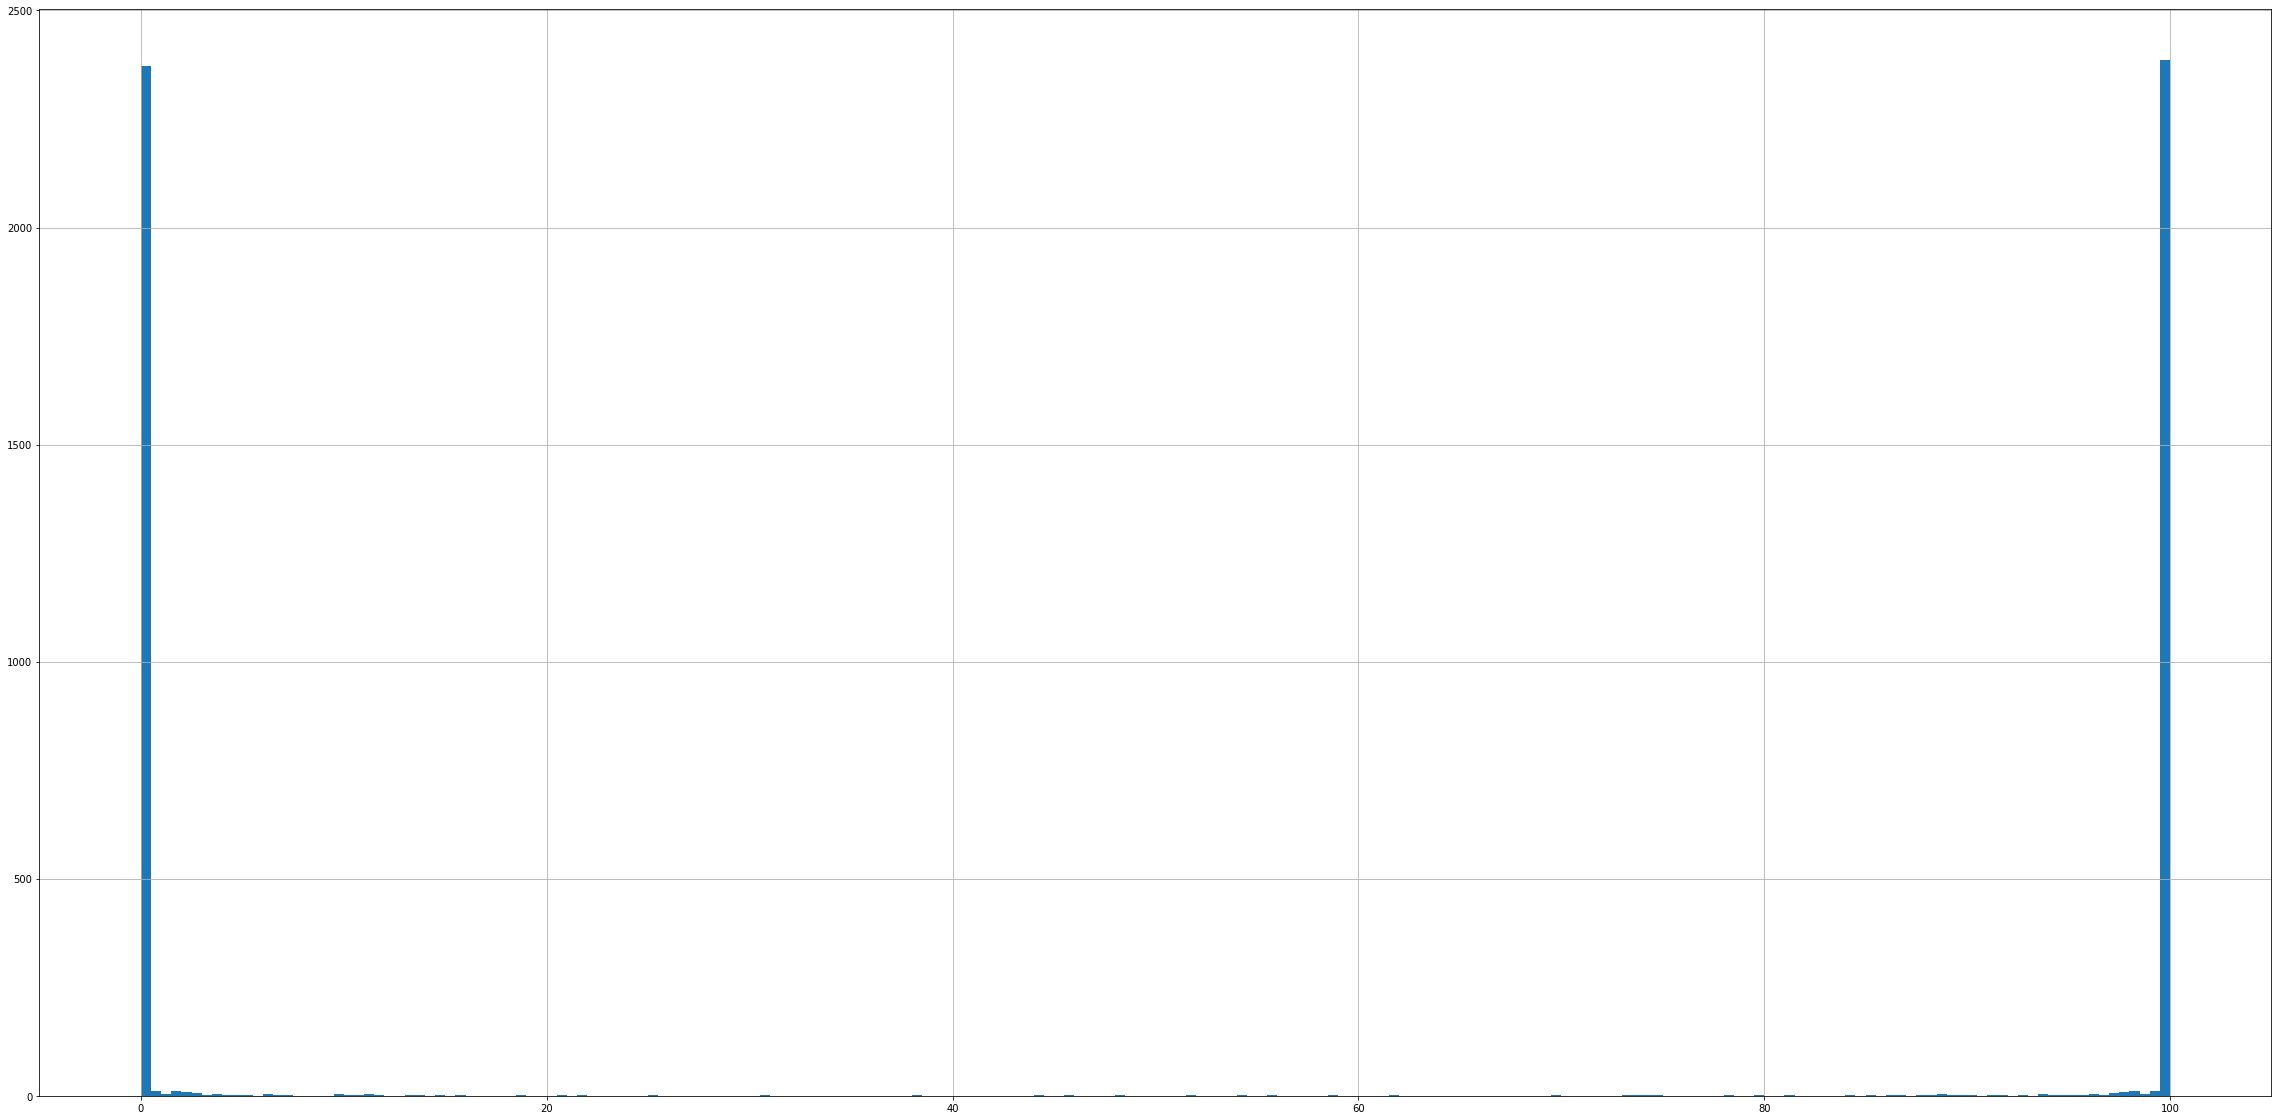

In [133]:
new_dataset["percentage"] = new_dataset["intersection"] / new_dataset["area"] * 100
new_dataset["percentage"].hist(bins = 200, figsize = (40,20))
plt.show()

In [152]:
municipals = pd.read_excel("Municipalities/ตารางแสดงรหัส-อปท-ปีงบประมาณ-2562.xlsx")
municipals["ชื่ออปท."] = municipals["ชื่ออปท."].str.replace(" ", "")

In [153]:
municipals

รหัสอปท.                                      ชื่ออปท.          อำเภอ  \
0       100001  องค์กรปกครองท้องถิ่นรูปแบบพิเศษกรุงเทพมหานคร            NaN   
1      1200401     องค์กรปกครองท้องถิ่นรูปแบบพิเศษเมืองพัทยา       บางละมุง   
2      2810101                องค์การบริหารส่วนจังหวัดกระบี่    เมืองกระบี่   
3      4810102                             เทศบาลเมืองกระบี่    เมืองกระบี่   
4      5810109                          เทศบาลตำบลกระบี่น้อย    เมืองกระบี่   
...        ...                                           ...            ...   
7847   6342402                 องค์การบริหารส่วนตำบลเหล่าแดง       ดอนมดแดง   
7848   6341408                  องค์การบริหารส่วนตำบลเหล่าบก     ม่วงสามสิบ   
7849   6341118                 องค์การบริหารส่วนตำบลไหล่ทุ่ง    ตระการพืชผล   
7850   6341915                 องค์การบริหารส่วนตำบลอ่างศิลา  พิบูลมังสาหาร   
7851   6340206                องค์การบริหารส่วนตำบลเอือดใหญ่   ศรีเมืองใหม่   

            จังหวัด  
0     กรุงเทพมหานคร  
1            ชลบุรี  
2            กระบี่  
3            กระบี่  
4            กระบี่  
...             ...  
7847    อุบลราชธานี  
7848    อุบลราชธานี  
7849    อุบลราชธานี  
7850    อุบลราชธานี  
7851    อุบลราชธานี  

[7852 rows x 4 columns]

In [227]:
new_dataset.NAME_TH = new_dataset.NAME_TH.str.replace(" ", "")
new_df = new_dataset.merge(municipals, left_on = ["NAME_TH", "A_NAME_TH", "P_NAME_TH"], right_on = ["ชื่ออปท.", "อำเภอ", "จังหวัด"], how = "left")\
    .dropna(subset = "ชื่ออปท.").drop(columns = ["ชื่ออปท.", "อำเภอ", "จังหวัด"]).rename(columns = {"รหัสอปท.": "DLA_CODE"})
new_df = pd.concat([new_df, nakhon])
new_df = new_df.drop(columns = ["OBJECTID", "DLA_TYPE", "VALID_TO"])
new_df["DLA_CODE"] = new_df["DLA_CODE"].astype(int).astype(str)
new_df.to_file("new_datasets/Municipalities/municipalities.geojson", encoding = "utf-8")

c:\Users\kittapat.ra\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [205]:
import geopandas as gpd
gpd.read_file("new_datasets/municipalities.shp")

NAME_TH                         NAME_EN PA_CODE  \
0          เทศบาลตำบลขัวมุง          KHUA MUNG MUNICIPALITY    5019   
1        เทศบาลตำบลท่ากว้าง          THA KWANG MUNICIPALITY    5019   
2            เทศบาลตำบลชมภู            CHOMPHU MUNICIPALITY    5019   
3         เทศบาลตำบลไชยสถาน      CHAIYA SATHAN MUNICIPALITY    5019   
4         เทศบาลตำบลดอนแก้ว           DON KAEO MUNICIPALITY    5019   
...                     ...                             ...     ...   
2458      เทศบาลนครเกาะสมุย      KO SAMUI CITY MUNICIPALITY    8404   
2459      เทศบาลนครเกาะสมุย      KO SAMUI CITY MUNICIPALITY    8404   
2460  เทศบาลเมืองแม่ฮ่องสอน  MAE HONG SON TOWN MUNICIPALITY    5801   
2461        เทศบาลเมืองเบตง        BETONG TOWN MUNICIPALITY    9502   
2462  เทศบาลตำบลธารน้ำทิพย์      THAN NAM THIP MUNICIPALITY    9502   

                A_NAME_EN        A_NAME_TH P_CODE     P_NAME_EN     P_NAME_TH  \
0                 Saraphi            สารภี     50    Chiang Mai     เชียงใหม่   
1                 Saraphi            สารภี     50    Chiang Mai     เชียงใหม่   
2                 Saraphi            สารภี     50    Chiang Mai     เชียงใหม่   
3                 Saraphi            สารภี     50    Chiang Mai     เชียงใหม่   
4                 Saraphi            สารภี     50    Chiang Mai     เชียงใหม่   
...                   ...              ...    ...           ...           ...   
2458             Ko Samui         เกาะสมุย     84   Surat Thani  สุราษฎร์ธานี   
2459             Ko Samui         เกาะสมุย     84   Surat Thani  สุราษฎร์ธานี   
2460  Mueang Mae Hong Son  เมืองแม่ฮ่องสอน     58  Mae Hong Son    แม่ฮ่องสอน   
2461               Betong             เบตง     95          Yala          ยะลา   
2462               Betong             เบตง     95          Yala          ยะลา   

        VALID_ON VALID_TO DLA_CODE  \
0     2022-01-22     None  5501906   
1     2022-01-22     None  5501908   
2     2022-01-22     None  5501904   
3     2022-01-22     None  5501905   
4     2022-01-22     None  5501907   
...          ...      ...      ...   
2458  2022-01-22     None  3840401   
2459  2022-01-22     None  3840401   
2460  2022-01-22     None  4580102   
2461  2022-01-22     None  4950201   
2462  2022-01-22     None  5950203   

                                               geometry  
0     POLYGON ((98.99462 18.68672, 98.99463 18.68672...  
1     POLYGON ((99.00107 18.68160, 99.00126 18.68153...  
2     POLYGON ((99.06627 18.72541, 99.06645 18.72526...  
3     POLYGON ((99.05029 18.76131, 99.05006 18.76129...  
4     POLYGON ((98.98603 18.71367, 98.98829 18.71287...  
...                                                 ...  
2458  POLYGON ((100.08788 9.57422, 100.08794 9.57421...  
2459  POLYGON ((100.06912 9.59352, 100.06931 9.59341...  
2460  POLYGON ((97.96358 19.31210, 97.96454 19.31208...  
2461  POLYGON ((101.01242 5.83755, 101.01249 5.83749...  
2462  POLYGON ((101.08395 5.76980, 101.08435 5.76959...  

[2463 rows x 12 columns]

In [90]:
def PAT_check(x):
    if type(x["อำเภอ"]) != str:
        return [gdf_ref[gdf_ref.P_NAME_T == x["จังหวัด"]]["P_CODE"].tolist()[0], gdf_ref[gdf_ref.P_NAME_T == x["จังหวัด"]]["geometry"].unary_union]
    elif (type(x["ตำบล"]) != str):
        if x["จังหวัด"] != "กรุงเทพมหานคร":
            result = gdf_ref[(gdf_ref.P_NAME_T == x["จังหวัด"]) & (gdf_ref.A_NAME_T == x["อำเภอ"])]
            return [result["PA_CODE"].tolist()[0], result["geometry"].unary_union]
        else:
            result = bkk_shape[bkk_shape.DISTRICT_N == x["อำเภอ"]]
            return [result["DISTRICT_I"].tolist()[0], result["geometry"].unary_union]
    else:
        if x["จังหวัด"] == "กรุงเทพมหานคร":
            result = bkk_shape[(bkk_shape.DISTRICT_N == x["อำเภอ"]) & (bkk_shape.SUBDISTR_1 == x["ตำบล"])]
            return [result["SUBDISTRIC"].tolist()[0], result["geometry"].unary_union]
        elif re.findall("เทศบาล",x["ตำบล"]) == []:
            result = gdf_ref[(gdf_ref.P_NAME_T == x["จังหวัด"]) & (gdf_ref.A_NAME_T == x["อำเภอ"]) & (gdf_ref.T_NAME_T == x["ตำบล"])]
            return [result["PAT_CODE"].tolist()[0], result["geometry"].unary_union]
        elif type(x["optional"]) == str:
            if re.findall("เทศบาล",x["optional"]) == []:
                result = gdf_ref[(gdf_ref.P_NAME_T == x["จังหวัด"]) & (gdf_ref.A_NAME_T == x["อำเภอ"]) & (gdf_ref.T_NAME_T == x["optional"])]
                return [result["PAT_CODE"].tolist()[0], result["geometry"].unary_union]
        else:
            result = gdf_ref[(gdf_ref.P_NAME_T == x["จังหวัด"]) & (gdf_ref.A_NAME_T == x["อำเภอ"])]
            return [result["PA_CODE"].tolist()[0], result["geometry"].unary_union]
        
def DLA_check(x):
    print(x["ตำบล"], x["optional"])
    if type(x["ตำบล"]) == str:
        if re.findall("เทศบาล",x["ตำบล"]) != []:
            result = municipal[municipal["DLA_NAME"] == x["ตำบล"]]
            if len(result) > 0:
                return [result["DLA_CODE"].tolist()[0], result["geometry"].unary_union]
    if type(x["optional"]) == str:
        if re.findall("เทศบาล",x["optional"]) != []:
            result = municipal[municipal["DLA_NAME"] == x["optional"]]
            return [result["DLA_CODE"].tolist()[0], result["geometry"].unary_union]      

ECT_map = last_dgg.copy()
ECT_map["PAT"] = last_dgg.apply(PAT_check, axis = 1)
ECT_map["DLA"] = last_dgg.apply(DLA_check, axis = 1)

ECT_map

None None
None None
None None
None None
None None
None None
None None
มะขามเฒ่า None
หนองน้อย None
หนองบัว None
เทศบาลตำบลวัดสิงห์ None
หนองขุ่น None
None None
None None
None None
None None
มะขามเฒ่า None
หนองน้อย None
หนองบัว None
เทศบาลตำบลวัดสิงห์ None
หนองขุ่น None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
มุกดาหาร None
ศรีบุญเรือง None
คำอาฮวน None
ดงเย็น None
บางทรายใหญ่ None
บ้านโคก None
คำป่าหลาย None
กุดแข้ None
นาสีนวน None
โพนทราย None
None None
None None
ผึ่งแดด None
ดงมอน None
นาโสก None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
ทุ่งนุ้ย None
None None
None None
None None
None None
ทุ่งนุ้ย None
None None
None None
ม่วงเตี้ย None
สาวร้องไห้ None
None None
None None
None None
None None
ม่วงเตี้ย None
สาวร้องไห้ None
None None
None N

IndexError: list index out of range

In [23]:
ECT_map[ECT_map["จังหวัด"] == "ลำปาง"]

จังหวัด  เขต       อำเภอ                   ตำบล    flag        optional  \
103   ลำปาง    1  เมืองลำปาง                บ้านแลง  ยกเว้น            None   
103   ลำปาง    1  เมืองลำปาง              บ้านเสด็จ  ยกเว้น            None   
103   ลำปาง    1  เมืองลำปาง  เทศบาลเมืองเขลางค์นคร  ยกเว้น            None   
103   ลำปาง    1  เมืองลำปาง                  พิชัย   เฉพาะ  เทศบาลนครลำปาง   
103   ลำปาง    1    ห้างฉัตร                   None     NaN            None   
104   ลำปาง    2  เมืองลำปาง                บ้านแลง   เฉพาะ            None   
104   ลำปาง    2  เมืองลำปาง              บ้านเสด็จ   เฉพาะ            None   
104   ลำปาง    2         งาว                   None     NaN            None   
104   ลำปาง    2      แจ้ห่ม                   None     NaN            None   
104   ลำปาง    2    วังเหนือ                   None     NaN            None   
104   ลำปาง    2    เมืองปาน                   None     NaN            None   
105   ลำปาง    3  เมืองลำปาง  เทศบาลเมืองเขลางค์นคร   เฉพาะ            None   
105   ลำปาง    3  เมืองลำปาง                  พิชัย  ยกเว้น  เทศบาลนครลำปาง   
105   ลำปาง    3     แม่เมาะ                   None     NaN            None   
105   ลำปาง    3       แม่ทะ                   None     NaN            None   
106   ลำปาง    4      เกาะคา                   None     NaN            None   
106   ลำปาง    4    เสริมงาม                   None     NaN            None   
106   ลำปาง    4        เถิน                   None     NaN            None   
106   ลำปาง    4     แม่พริก                   None     NaN            None   
106   ลำปาง    4      สบปราบ                   None     NaN            None   

                                                   PAT  \
103  [520109, POLYGON ((99.69209458500006 18.610530...   
103  [520110, POLYGON ((99.66719781700004 18.372215...   
103  [5201, POLYGON ((99.57452857700008 18.21353034...   
103  [520111, POLYGON ((99.58883304900007 18.376934...   
103  [5212, POLYGON ((99.29471198800007 18.25866978...   
104  [520109, POLYGON ((99.69209458500006 18.610530...   
104  [520110, POLYGON ((99.66719781700004 18.372215...   
104  [5205, POLYGON ((100.10452886200005 18.6895656...   
104  [5206, POLYGON ((99.77691299200006 18.73235692...   
104  [5207, POLYGON ((99.72643497300004 19.16984375...   
104  [5213, POLYGON ((99.51491453900007 18.61199258...   
105  [5201, POLYGON ((99.57452857700008 18.21353034...   
105  [520111, POLYGON ((99.58883304900007 18.376934...   
105  [5202, POLYGON ((99.86305285500003 18.28038284...   
105  [5210, POLYGON ((99.73799417400005 18.10542643...   
106  [5203, POLYGON ((99.43287863100005 18.12914500...   
106  [5204, POLYGON ((99.24940629600007 18.15932062...   
106  [5208, POLYGON ((99.43855552800005 17.52643192...   
106  [5209, POLYGON ((99.16021576300005 17.50981544...   
106  [5211, POLYGON ((99.41611162400005 17.83759426...   

                                                   DLA  
103                                               None  
103                                               None  
103  [4520103, POLYGON ((99.44483112121128 18.29479...  
103  [3520102, POLYGON ((99.51053295908689 18.30907...  
103                                               None  
104                                               None  
104                                               None  
104                                               None  
104                                               None  
104                                               None  
104                                               None  
105  [4520103, POLYGON ((99.44483112121128 18.29479...  
105  [3520102, POLYGON ((99.51053295908689 18.30907...  
105                                               None  
105                                               None  
106                                               None  
106                                               None  
106                                               None  
106                                       

In [24]:
ECT_map["PAT_code"] = ECT_map["PAT"].apply(lambda x: x[0]).astype(str)
ECT_map["PAT_geometry"] = ECT_map["PAT"].apply(lambda x: x[1])
ECT_map["DLA_code"] = ECT_map["DLA"].apply(lambda x: str(int(x[0])) if x else x).astype(str)
ECT_map["DLA_geometry"] = ECT_map["DLA"].apply(lambda x: x[1] if x else x)

ECT_map.drop(columns = ["DLA", "PAT"])#.drop_duplicates()

จังหวัด  เขต        อำเภอ        ตำบล    flag optional PAT_code  \
0             ตราด    1          NaN        None     NaN     None       23   
1            ระนอง    1          NaN        None     NaN     None       85   
2      สมุทรสงคราม    1          NaN        None     NaN     None       75   
3        สิงห์บุรี    1          NaN        None     NaN     None       17   
4           ชัยนาท    1  เมืองชัยนาท        None     NaN     None     1801   
..             ...  ...          ...         ...     ...      ...      ...   
398  กรุงเทพมหานคร   32       ธนบุรี  วัดกัลยาณ์   เฉพาะ     None   101501   
398  กรุงเทพมหานคร   32       ธนบุรี   หิรัญรูจี   เฉพาะ     None   101502   
398  กรุงเทพมหานคร   32       ธนบุรี  บางยี่เรือ   เฉพาะ     None   101503   
399  กรุงเทพมหานคร   33      บางพลัด        None     NaN     None     1025   
399  กรุงเทพมหานคร   33   บางกอกน้อย     ศิริราช  ยกเว้น     None   102004   

                                          PAT_geometry DLA_code DLA_geometry  
0    MULTIPOLYGON (((102.39148749700007 11.77126791...     None         None  
1    MULTIPOLYGON (((98.53014857200009 9.3444056990...     None         None  
2    POLYGON ((99.98938576800003 13.326856188000022...     None         None  
3    POLYGON ((100.34865218000004 14.77987036400003...     None         None  
4    POLYGON ((100.16501011400004 15.15272789000005...     None         None  
..                                                 ...      ...          ...  
398  POLYGON ((100.48787159608105 13.73601705390707...     None         None  
398  POLYGON ((100.494842931108 13.730858373444468,...     None         None  
398  POLYGON ((100.48621874597987 13.72746809908421...     None         None  
399  POLYGON ((100.50248272007764 13.78099956308650...     None         None  
399  POLYGON ((100.47295830758573 13.76285604651609...     None         None  

[2185 rows x 10 columns]

307 Mun

In [66]:
len(municipal_map[
    municipal_map["รหัสอปท."].\
        astype(str).str.\
            contains(
                "|".join(ECT_map[ECT_map.DLA_code != "None"]["DLA_code"].tolist())
                )
            ])

50

In [25]:
type(ECT_map["DLA_geometry"].dropna()[4])

shapely.geometry.polygon.Polygon

In [26]:
import shapely
PAT = gdf_ref[["PAT_CODE", "geometry"]].dropna()
DLA = ECT_map[["DLA_code", "DLA_geometry"]].dropna().drop_duplicates().copy()
DLA = gpd.GeoDataFrame(DLA, geometry = "DLA_geometry", crs = "EPSG:4326")
Cross_join = []
for _, dla in DLA.iterrows():
    for _, pat in PAT.iterrows():
        Cross_join.append({
            "PAT_code": pat[0],
            "DLA_code": dla[0],
            "geometry": shapely.intersection(pat[1], dla[1]) 
        })

final_region = gpd.GeoDataFrame(Cross_join)
final_region

C:\Users\kittapat.ra\AppData\Roaming\Python\Python39\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


PAT_code DLA_code       geometry
0        110101  5180301  POLYGON EMPTY
1        110102  5180301  POLYGON EMPTY
2        110103  5180301  POLYGON EMPTY
3        110104  5180301  POLYGON EMPTY
4        110108  5180301  POLYGON EMPTY
...         ...      ...            ...
362795   961203  5800106  POLYGON EMPTY
362796   961204  5800106  POLYGON EMPTY
362797   961301  5800106  POLYGON EMPTY
362798   961302  5800106  POLYGON EMPTY
362799   961303  5800106  POLYGON EMPTY

[362800 rows x 3 columns]

In [27]:
final_region = final_region[final_region.geometry.apply(lambda x: x.is_empty)]
PAT_regions = []
for _, pat in tqdm(PAT.iterrows()):
    focused = final_region[final_region["PAT_code"] == pat[0]]["geometry"].tolist()
    union = shapely.unary_union(focused)
    PAT_regions.append({
        "PAT_code": pat[0],
        "DLA_code": None,
        "geometry": shapely.difference(pat[1], union)
    })
last_region = pd.concat([gpd.GeoDataFrame(PAT_regions), final_region])
last_region

7256it [02:07, 56.96it/s]


PAT_code DLA_code                                           geometry
0        110101     None  POLYGON ((100.60612 13.57839, 100.60547 13.576...
1        110102     None  POLYGON ((100.60132 13.65703, 100.60281 13.656...
2        110103     None  POLYGON ((100.62934 13.62186, 100.63039 13.621...
3        110104     None  POLYGON ((100.62151 13.54063, 100.62072 13.540...
4        110108     None  POLYGON ((100.63229 13.55314, 100.63315 13.552...
...         ...      ...                                                ...
362795   961203  5800106                                      POLYGON EMPTY
362796   961204  5800106                                      POLYGON EMPTY
362797   961301  5800106                                      POLYGON EMPTY
362798   961302  5800106                                      POLYGON EMPTY
362799   961303  5800106                                      POLYGON EMPTY

[369729 rows x 3 columns]

In [28]:
last_region = last_region[last_region.geometry.apply(lambda x: not(x.is_empty))]
last_region

PAT_code DLA_code                                           geometry
0      110101     None  POLYGON ((100.60612 13.57839, 100.60547 13.576...
1      110102     None  POLYGON ((100.60132 13.65703, 100.60281 13.656...
2      110103     None  POLYGON ((100.62934 13.62186, 100.63039 13.621...
3      110104     None  POLYGON ((100.62151 13.54063, 100.62072 13.540...
4      110108     None  POLYGON ((100.63229 13.55314, 100.63315 13.552...
...       ...      ...                                                ...
7251   961203     None  POLYGON ((101.71127 6.17059, 101.71205 6.17043...
7252   961204     None  POLYGON ((101.68554 6.08625, 101.68549 6.08545...
7253   961301     None  POLYGON ((101.85236 6.29831, 101.85390 6.29768...
7254   961302     None  POLYGON ((101.85688 6.22109, 101.85809 6.21962...
7255   961303     None  POLYGON ((101.89718 6.29751, 101.89732 6.29668...

[7256 rows x 3 columns]

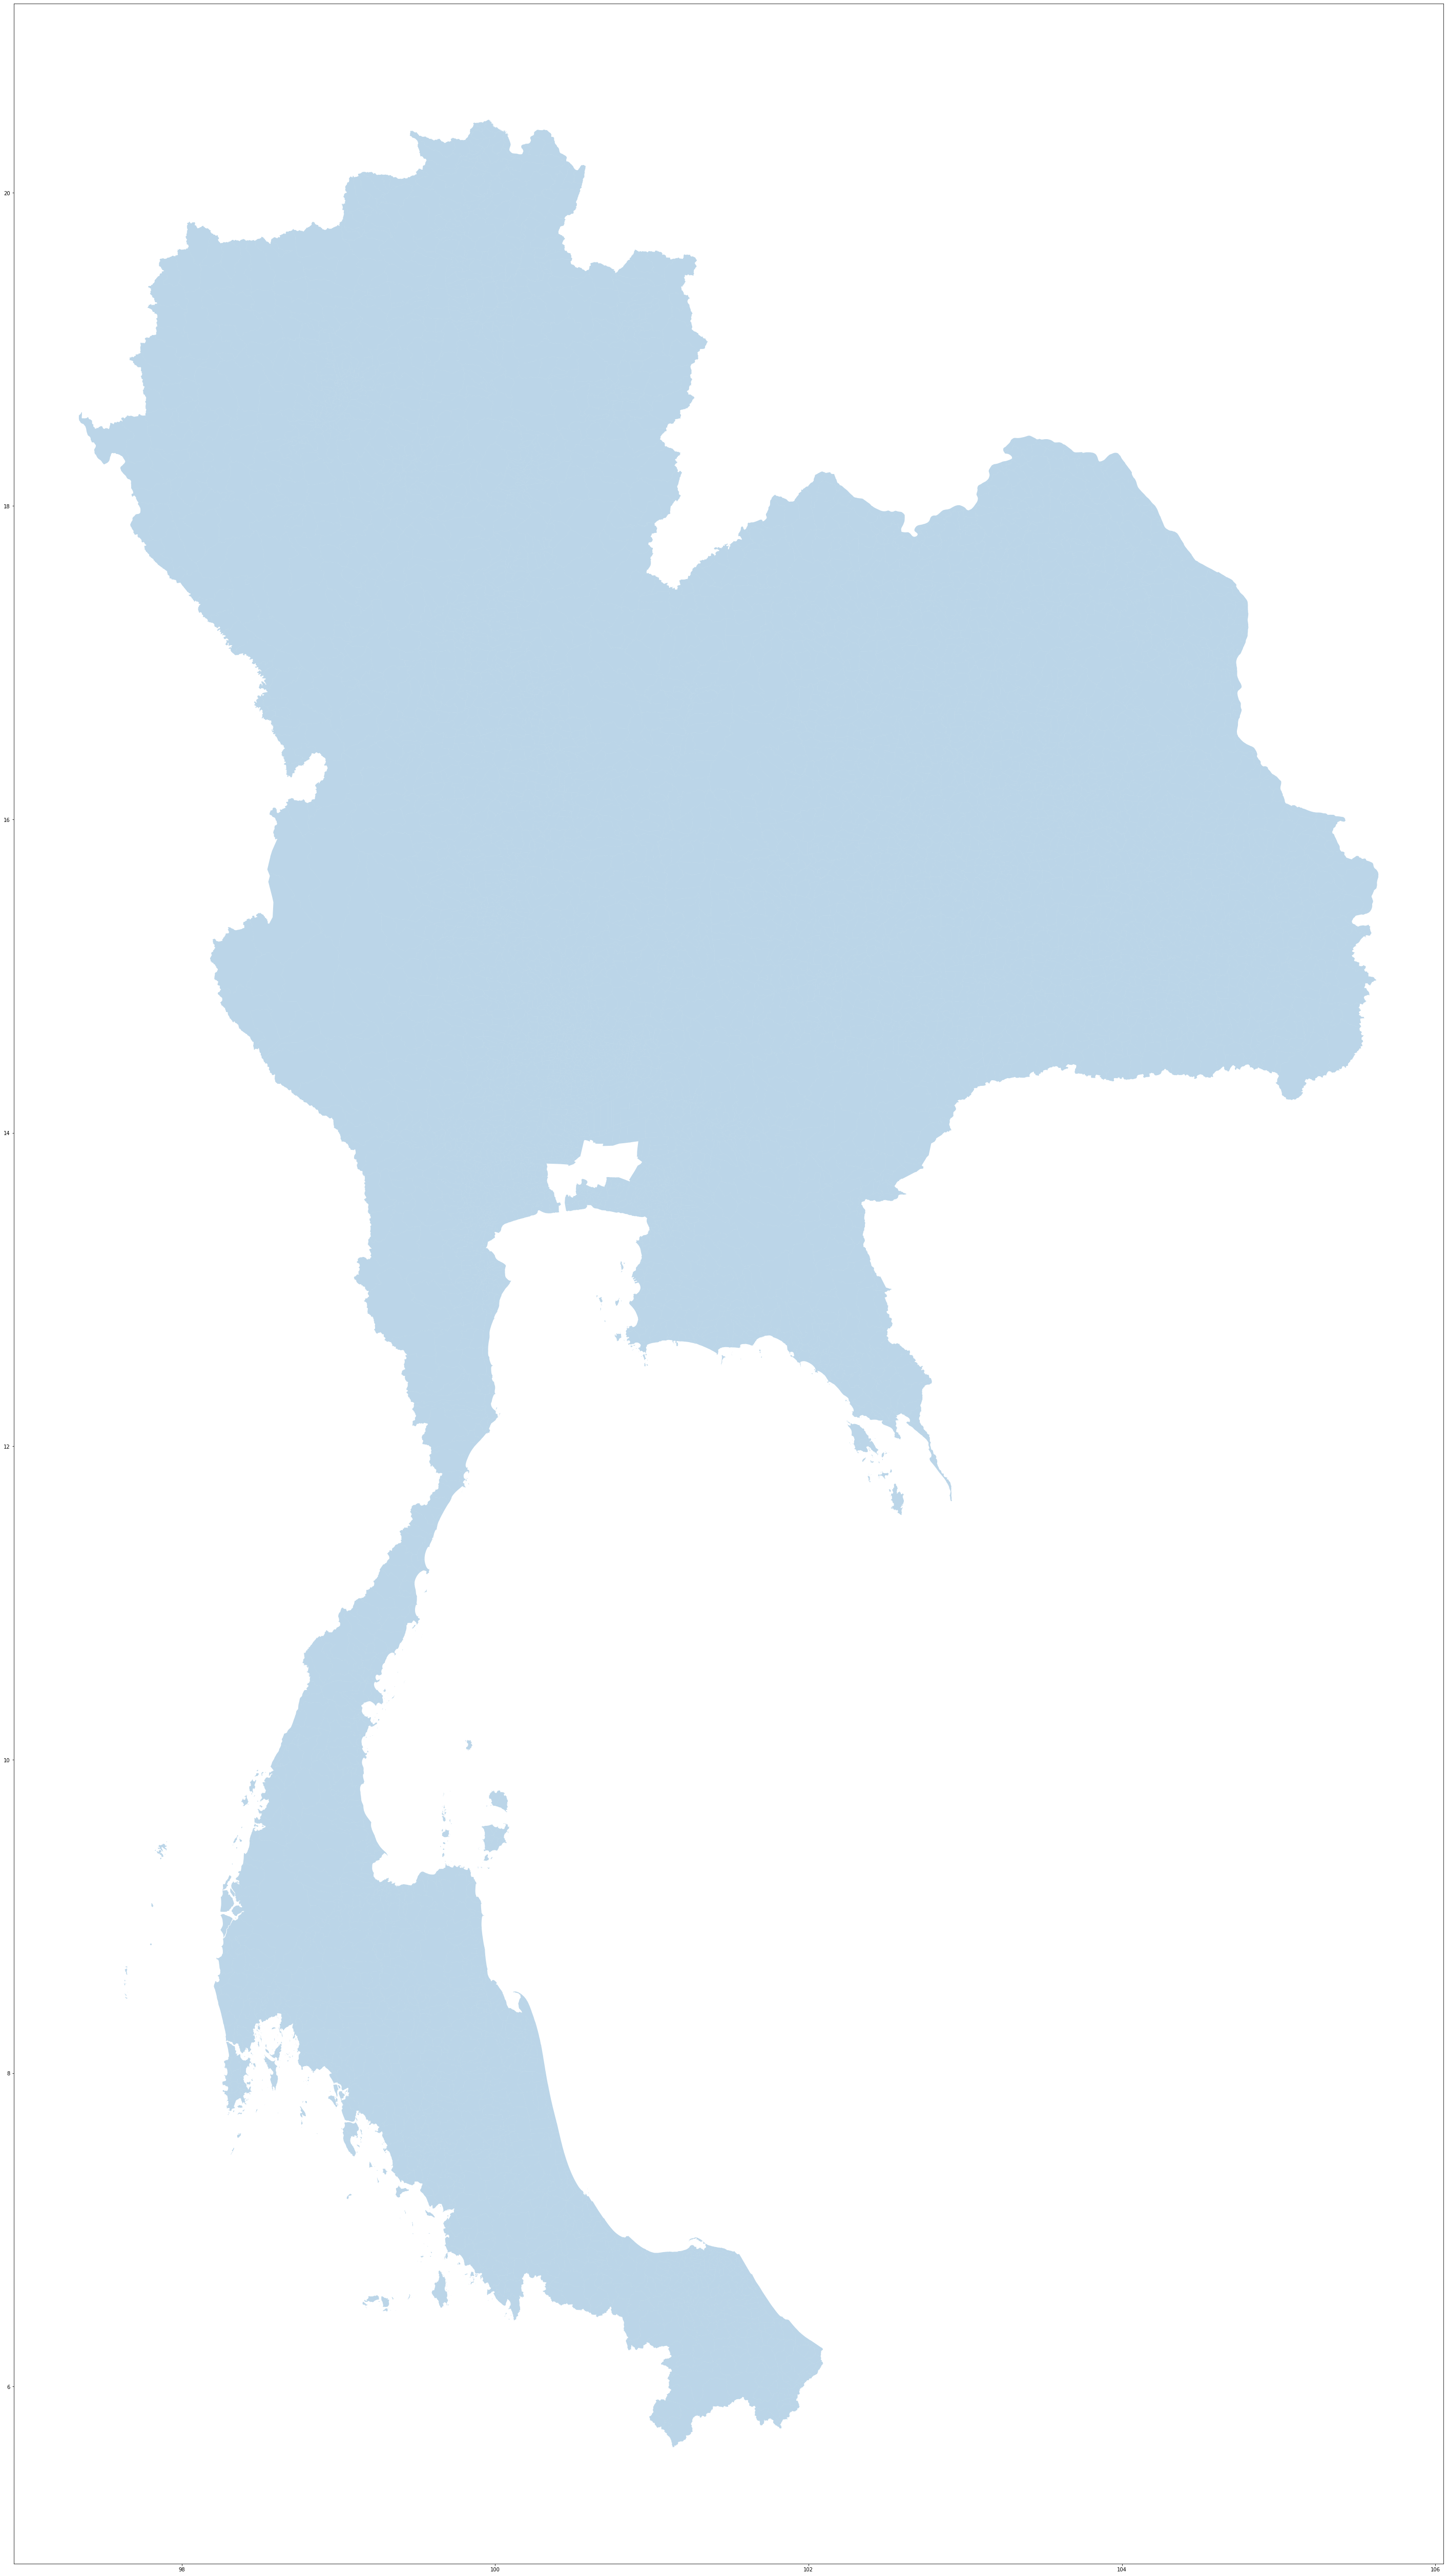

In [29]:
PAT_g = gpd.GeoDataFrame(last_region)
PAT_g.plot(figsize = (50,100), alpha = 0.3)
plt.show()

In [30]:
shapely.unary_union(PAT_g[PAT_g.PAT_code == "TH180302"].geometry.tolist())

In [31]:
last_region_df = pd.DataFrame(last_region)
last_region_df

PAT_code DLA_code                                           geometry
0      110101     None  POLYGON ((100.60612 13.57839, 100.60547 13.576...
1      110102     None  POLYGON ((100.60132 13.65703, 100.60281 13.656...
2      110103     None  POLYGON ((100.62934 13.62186, 100.63039 13.621...
3      110104     None  POLYGON ((100.62151 13.54063, 100.62072 13.540...
4      110108     None  POLYGON ((100.63229 13.55314, 100.63315 13.552...
...       ...      ...                                                ...
7251   961203     None  POLYGON ((101.71127 6.17059, 101.71205 6.17043...
7252   961204     None  POLYGON ((101.68554 6.08625, 101.68549 6.08545...
7253   961301     None  POLYGON ((101.85236 6.29831, 101.85390 6.29768...
7254   961302     None  POLYGON ((101.85688 6.22109, 101.85809 6.21962...
7255   961303     None  POLYGON ((101.89718 6.29751, 101.89732 6.29668...

[7256 rows x 3 columns]

In [32]:
c = last_region_df.drop(columns = "geometry")

In [33]:
def include_geo(x):
    if x["จังหวัด"] != "กรุงเทพมหานคร":
        if (x["DLA_code"] != "None") and (len(x["PAT_code"]) == 6):
            selected = last_region_df[(last_region_df.PAT_code == x["PAT_code"]) & (last_region_df.DLA_code == x["DLA_code"])]
        elif (x["DLA_code"] != "None"):
            if len(x["PAT_code"]) == 4:
                selected = last_region_df[(last_region_df.PAT_code.str[:4] == x["PAT_code"]) & (last_region_df.DLA_code == x["DLA_code"])]
                print(x["PAT_code"], x["DLA_code"])
                print(selected)
            else:
                selected = last_region_df[(last_region_df.PAT_code.str[:4] == x["PAT_code"]) & (last_region_df.DLA_code == x["DLA_code"])]
        else:
            if len(x["PAT_code"]) == 6:
                selected = last_region_df[(last_region_df.PAT_code == x["PAT_code"])]
            elif len(x["PAT_code"]) == 4:
                selected = last_region_df[(last_region_df.PAT_code.str[:4] == x["PAT_code"])]
            elif len(x["PAT_code"]) == 2:
                selected = last_region_df[(last_region_df.PAT_code.str[:2] == x["PAT_code"])]
        return [selected.PAT_code.tolist(), selected.DLA_code.tolist(), selected.geometry.tolist()]
    else:
        if len(x["PAT_code"]) == 6:
            selected = bkk_shape[(bkk_shape.SUBDISTRIC == x["PAT_code"])]
        else:
            selected = bkk_shape[(bkk_shape.DISTRICT_I == x["PAT_code"])]
        return [selected.SUBDISTRIC.tolist(), [None] * len(selected), selected.geometry.tolist()]
    
def exclude_geo(x):
    if x["จังหวัด"] != "กรุงเทพมหานคร":
        if type((x["optional"]).tolist()[0]) != str:
            if re.findall("เทศบาล", x["ตำบล"]) == []:
                selected = last_region_df[(last_region_df.PAT_code.str[:4] == x["PAT_code"][:4]) & (~(last_region_df.PAT_code == x["PAT_code"]))]
            else:
                selected = last_region_df[(last_region_df.PAT_code.str[:4] == x["PAT_code"]) & (~(last_region_df.DLA_code == x["DLA_code"]))]
        else:
            if re.findall("เทศบาล", x["ตำบล"]) == []:
                selected = last_region_df[(last_region_df.PAT_code == x["PAT_code"]) & (~(last_region_df.DLA_code == x["DLA_code"]))]
            else:
                selected = last_region_df[~(last_region_df.PAT_code == x["PAT_code"]) & (last_region_df.DLA_code == x["DLA_code"])]
        return [selected.PAT_code.tolist(), selected.DLA_code.tolist(), selected.geometry.tolist()]
    else:
        selected = bkk_shape[(bkk_shape.DISTRICT_I == x["PAT_code"][:4]) & ~(bkk_shape.SUBDISTRIC == x["PAT_code"])]
        return [selected.SUBDISTRIC.tolist(), [None] * len(selected), selected.geometry.tolist()]

def intersection_lists(x):
    summary = dict()
    repo = {"PAT_DLA": [], "Geometry": []}
    final_list_0 = []
    final_list_1 = []
    final_list_2 = []
    for element in x:
        for a,b,c in zip(element[0], element[1], element[2]):
            pat_dla = str(a) + "-" + str(b)
            try:
                summary[pat_dla] += 1
            except:
                summary[pat_dla] = 1
            if (pat_dla not in repo["PAT_DLA"]):
                repo["PAT_DLA"].append(pat_dla)
                repo["Geometry"].append(c)
        max_value = max(summary.values())
        for i, j in summary.items():
            if j == max_value:
                idx = repo["PAT_DLA"].index(i)
                splitted = i.split("-")
                final_list_0.append(splitted[0])
                final_list_1.append(splitted[1])
                final_list_2.append(repo["Geometry"][idx])
    return [final_list_0, final_list_1, final_list_2]


include_ECT = ECT_map[ECT_map.flag != "ยกเว้น"][["จังหวัด", "เขต", "อำเภอ", "PAT_code", "DLA_code", "optional"]].copy()
include_ECT["geometry"] = include_ECT.apply(include_geo, axis = 1)
include_ECT = include_ECT[["จังหวัด", "เขต", "อำเภอ", "geometry"]]
include_ECT["PAT_code"] = include_ECT.geometry.apply(lambda x: x[0])
include_ECT["DLA_code"] = include_ECT.geometry.apply(lambda x: x[1])
include_ECT["geometry"] = include_ECT.geometry.apply(lambda x: x[2])
include_ECT = include_ECT.explode(["PAT_code", "DLA_code", "geometry"])

exclude_ECT = ECT_map[ECT_map.flag == "ยกเว้น"][["จังหวัด", "เขต", "อำเภอ", "ตำบล", "optional", "PAT_code", "DLA_code", "optional"]].copy()
exclude_ECT["geometry"] = exclude_ECT.apply(exclude_geo, axis = 1)
exclude_ECT = exclude_ECT[["จังหวัด", "เขต", "อำเภอ", "geometry"]]
exclude_ECT = exclude_ECT.groupby(["จังหวัด", "เขต", "อำเภอ"])["geometry"].apply(list).apply(intersection_lists).reset_index()
exclude_ECT["PAT_code"] = exclude_ECT.geometry.apply(lambda x: x[0])
exclude_ECT["DLA_code"] = exclude_ECT.geometry.apply(lambda x: x[1])
exclude_ECT["geometry"] = exclude_ECT.geometry.apply(lambda x: x[2])
exclude_ECT = exclude_ECT.explode(["geometry", "PAT_code", "DLA_code"]).drop_duplicates()
exclude_ECT

1803 5180301
Empty DataFrame
Columns: [PAT_code, DLA_code, geometry]
Index: []
7706 5770602
Empty DataFrame
Columns: [PAT_code, DLA_code, geometry]
Index: []
2503 5250301
Empty DataFrame
Columns: [PAT_code, DLA_code, geometry]
Index: []
4801 4480102
Empty DataFrame
Columns: [PAT_code, DLA_code, geometry]
Index: []
5201 4520103
Empty DataFrame
Columns: [PAT_code, DLA_code, geometry]
Index: []
6506 5650601
Empty DataFrame
Columns: [PAT_code, DLA_code, geometry]
Index: []
6508 5650801
Empty DataFrame
Columns: [PAT_code, DLA_code, geometry]
Index: []
6509 5650902
Empty DataFrame
Columns: [PAT_code, DLA_code, geometry]
Index: []
6509 5650903
Empty DataFrame
Columns: [PAT_code, DLA_code, geometry]
Index: []
6509 5650901
Empty DataFrame
Columns: [PAT_code, DLA_code, geometry]
Index: []
2101 4210103
Empty DataFrame
Columns: [PAT_code, DLA_code, geometry]
Index: []
2101 5210107
Empty DataFrame
Columns: [PAT_code, DLA_code, geometry]
Index: []
2101 5210108
Empty DataFrame
Columns: [PAT_code, DLA

จังหวัด  เขต      อำเภอ  \
0    กระบี่    1  เหนือคลอง   
0    กระบี่    1  เหนือคลอง   
0    กระบี่    1  เหนือคลอง   
0    กระบี่    1  เหนือคลอง   
0    กระบี่    1  เหนือคลอง   
..      ...  ...        ...   
130    แพร่    1  เมืองแพร่   
130    แพร่    1  เมืองแพร่   
130    แพร่    1  เมืองแพร่   
130    แพร่    1  เมืองแพร่   
130    แพร่    1  เมืองแพร่   

                                              geometry PAT_code DLA_code  
0    POLYGON ((98.98142435800008 8.131437766000033,...   810801     None  
0    MULTIPOLYGON (((98.98300274300004 7.7772814890...   810802     None  
0    MULTIPOLYGON (((99.04461703300007 7.8662781980...   810803     None  
0    POLYGON ((99.01794541200007 8.033658031000073,...   810804     None  
0    POLYGON ((98.96358396500005 8.015212008000049,...   810806     None  
..                                                 ...      ...      ...  
130  POLYGON ((100.08441794400005 18.25288938600005...   540116     None  
130  POLYGON ((100.18091567500005 18.21479201800002...   540117     None  
130  POLYGON ((100.20239521500008 18.08764860300004...   540118     None  
130  POLYGON ((100.19328163400007 18.18050650100002...   540119     None  
130  POLYGON ((100.17944014400007 18.13685978300003...   540120     None  

[1086 rows x 6 columns]

In [34]:
final_ECT_gpd = gpd.GeoDataFrame(pd.concat([exclude_ECT, include_ECT]))

In [35]:
a = ECT_map[["จังหวัด", "เขต", "อำเภอ", "ตำบล", "flag", "optional", "PAT_code", "DLA_code"]]
b = final_ECT_gpd[["จังหวัด", "เขต", "อำเภอ", "PAT_code", "DLA_code"]]

In [36]:
check = final_ECT_gpd[final_ECT_gpd["จังหวัด"] != "กรุงเทพมหานคร"].merge(last_region_df, on = ["PAT_code", "DLA_code"], how = "right")
check.geometry_x.isnull().sum()

c:\Users\kittapat.ra\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\reshape\merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


833

In [37]:
color_map = final_ECT_gpd[["จังหวัด", "เขต"]].drop_duplicates()
color_map["color"] = ["#" + "".join(np.random.choice(list("0123456789ABCDEF"), size = 6)) for _ in range(len(color_map))]
color_map

จังหวัด  เขต    color
0           กระบี่    1  #2F236E
1    กรุงเทพมหานคร    1  #655C8D
2    กรุงเทพมหานคร    5  #933884
3    กรุงเทพมหานคร    8  #81979F
5    กรุงเทพมหานคร    9  #B6879D
..             ...  ...      ...
380  กรุงเทพมหานคร   14  #FAA20C
381  กรุงเทพมหานคร   15  #083300
384  กรุงเทพมหานคร   18  #703500
388  กรุงเทพมหานคร   22  #5D608C
389  กรุงเทพมหานคร   23  #519CDD

[400 rows x 3 columns]

In [38]:
colored = final_ECT_gpd.merge(color_map)

In [39]:
to_plot = colored[colored["จังหวัด"] == "เพชรบูรณ์"]
to_plot

จังหวัด  เขต           อำเภอ  \
1995  เพชรบูรณ์    2  เมืองเพชรบูรณ์   
1996  เพชรบูรณ์    2  เมืองเพชรบูรณ์   
1997  เพชรบูรณ์    2  เมืองเพชรบูรณ์   
1998  เพชรบูรณ์    2  เมืองเพชรบูรณ์   
1999  เพชรบูรณ์    2  เมืองเพชรบูรณ์   
...         ...  ...             ...   
5340  เพชรบูรณ์    4         หนองไผ่   
5341  เพชรบูรณ์    4         หนองไผ่   
5342  เพชรบูรณ์    4         หนองไผ่   
5343  เพชรบูรณ์    4         หนองไผ่   
5344  เพชรบูรณ์    4         หนองไผ่   

                                               geometry PAT_code DLA_code  \
1995  POLYGON ((101.14939 16.43801, 101.15045 16.437...   670101     None   
1996  POLYGON ((101.34745 16.37558, 101.34770 16.375...   670102     None   
1997  POLYGON ((101.02514 16.40717, 101.02529 16.407...   670103     None   
1998  POLYGON ((101.16542 16.46442, 101.16545 16.464...   670104     None   
1999  POLYGON ((100.94692 16.51370, 100.94730 16.513...   670105     None   
...                                                 ...      ...      ...   
5340                                               None      NaN      NaN   
5341                                               None      NaN      NaN   
5342                                               None      NaN      NaN   
5343  POLYGON ((101.03329 16.17039, 101.03348 16.170...   670707     None   
5344  POLYGON ((100.97449 16.14295, 100.97440 16.138...   670712     None   

        color  
1995  #645BEB  
1996  #645BEB  
1997  #645BEB  
1998  #645BEB  
1999  #645BEB  
...       ...  
5340  #6BEADE  
5341  #6BEADE  
5342  #6BEADE  
5343  #6BEADE  
5344  #6BEADE  

[155 rows x 7 columns]

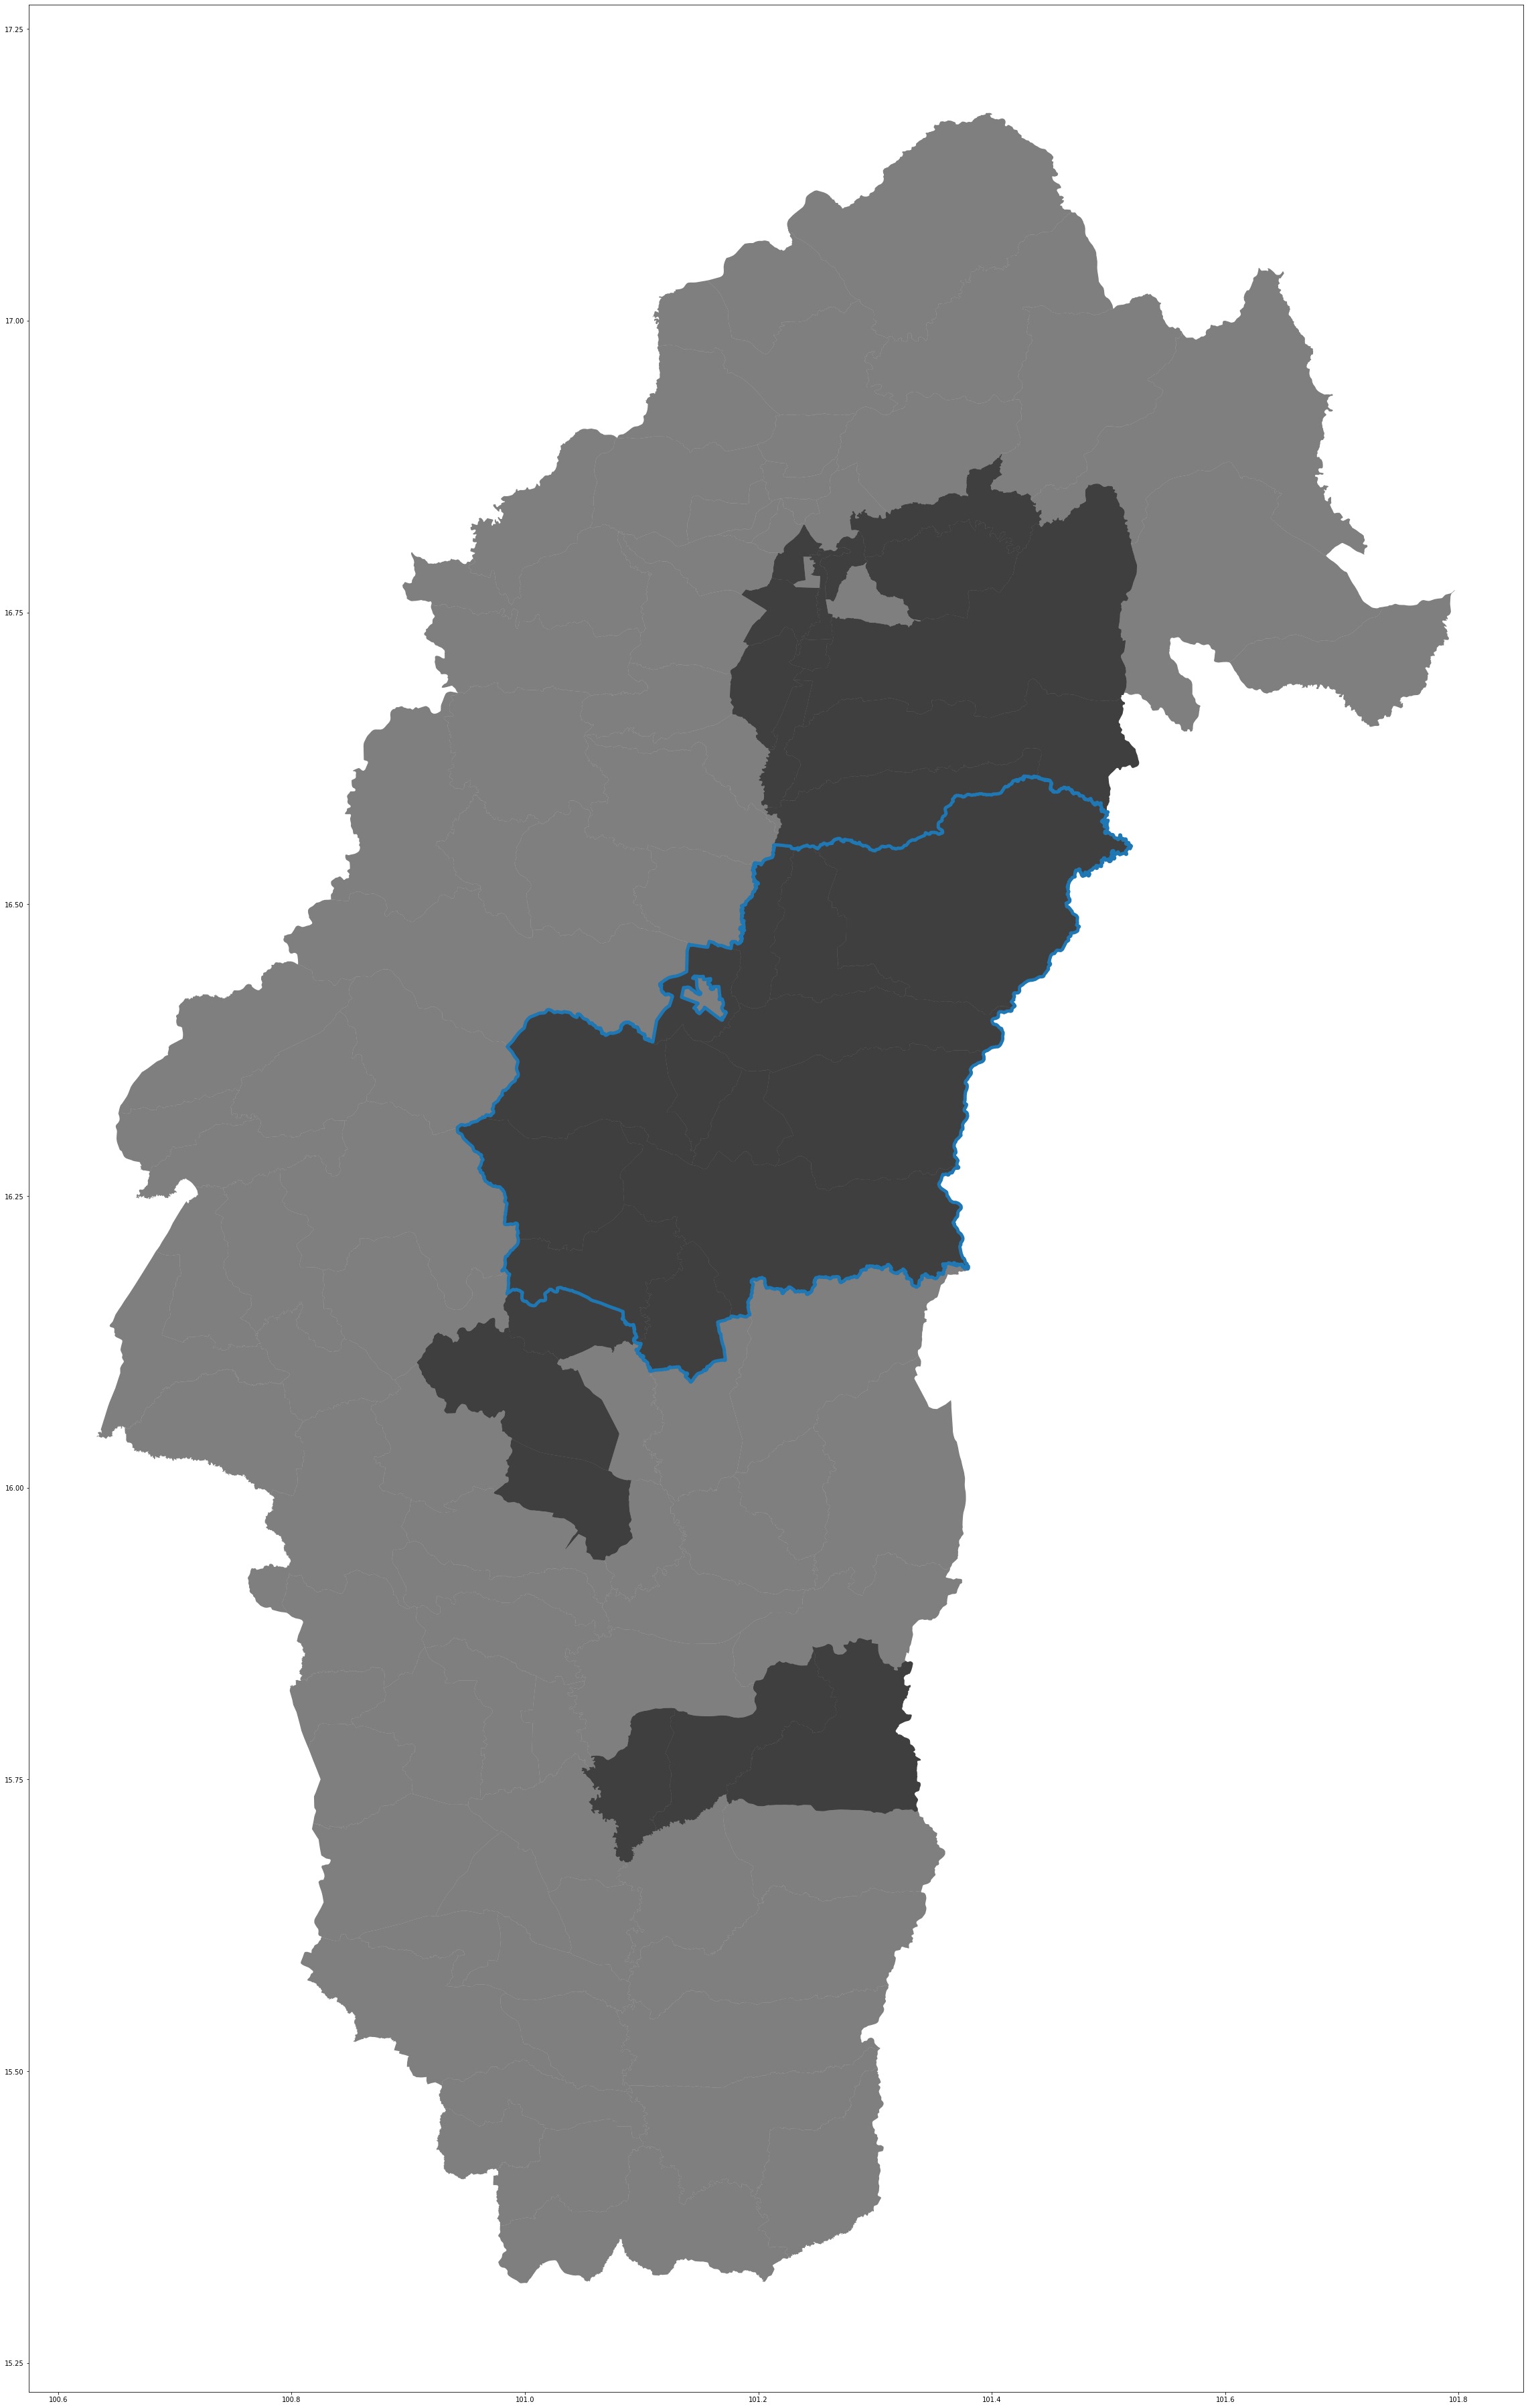

In [40]:
_, ax = plt.subplots(figsize = (40,80))
to_plot.plot(color = "#000000", ax = ax, alpha = 0.5)
gpd.GeoDataFrame(geometry = [to_plot[(to_plot["เขต"] == 1)].geometry.unary_union], crs = to_plot.crs).boundary.plot(ax = ax, linewidth = 5)
plt.show()